# PREDICTING SOLAR ENERGY OUTPUT AND CONSUMPTION
![sdjf](Files/american-public-power-association-XGAZzyLzn18-unsplash.jpg)
_Photo by American Public Power Association on Unsplash_

---

> * ___Given weather conditions, how much solar power will the solar plants output?___  
> * ___Further, how much solar power will a little town demand?___

A small town in Spain is sourced by solar energy thanks to a solar plant. Over a year (2015), the plant's energy output and the town's energy consumption data were gathered; and along with it, data from a nearby meteorological station. 

We are given both datasets and we would like to be able to know both energy output and energy consumption beforehand for the near future –– in other words, we would like to come with a model that predicts the amount of energy output/consumption given a set of weather conditions.

In this notebook we will employ several machine learning techniques to tackle these tasks. One important thing to note is that the records are provided with 5-minute difference (meteorological data) and hourly (output/consumption). This means that we will have to normalize all records to an hourly basis and thus to come with a dataset that tells _how much output/consumption was, given the mean weather conditions in the last hour_.

A second thing to note is that we can try to predict with the same hourly basis, _i.e._ the next hour, or to predict the data for the next day. The latter would perhaps make more sense as the town can do much more with day-to-day information. This is important because a model will be more or less accurate depending on the time window to predict.

---
## Contents

1. Data Preparation
    1. Data cleaning
    2. Data merging
 

2. Predicting energy consumption
    1. Data preparation
    2. Multi-feature linear regression
    3. Single-feature, auto-regressive linear regression
    4. Single-feature, auto-regressive long short-term memory (LSTM) recurrent neural network (RNN)
    5. Multi-feature, auto-regressive LSTM RNN.


3. Summary

## 1. Data Preparation
---

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
#
sns.set()
sns.set_style("whitegrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 140
#
#warnings.filterwarnings('ignore')

* __Meteo.csv__ –– Contains meteorological information from a weather station close to the solar panels and the town. Units are in US standard units.

* __Datos_solar_y_demanda_residencial.xls__ –– Data from a solar plant, a rooftop test photovoltaic cell (PV2 Parque) and the consumption from the town (Demanda).

In [2]:
#=======================================================  Meteo.csv
path = "/Users/hramirez/GitHub/Renewable_Energy/files/"

Meteo = pd.read_csv(path + "Meteo.csv", parse_dates=[['Date', 'Time']])
Meteo.head()

Date_Time Temperature Dew Point Humidity  Wind    Speed     Gust  \
0 2015-01-01 01:01:00      31.5 F    23.2 F     71 %  West  0.0 mph  2.2 mph   
1 2015-01-01 01:08:00      31.2 F    22.9 F     71 %  West  0.0 mph  1.2 mph   
2 2015-01-01 01:11:00      30.6 F    22.3 F     71 %  West  0.0 mph  1.6 mph   
3 2015-01-01 01:16:00      30.4 F    22.1 F     71 %   WNW  0.0 mph  1.6 mph   
4 2015-01-01 01:21:00      30.0 F    21.8 F     71 %    NW  0.0 mph  1.6 mph   

   Pressure Precip. Rate. Precip. Accum.  UV   Solar  
0  29.87 in       0.00 in        0.00 in NaN   w/m²   
1  29.87 in       0.00 in        0.00 in NaN   w/m²   
2  29.87 in       0.00 in        0.00 in NaN   w/m²   
3  29.86 in       0.00 in        0.00 in NaN   w/m²   
4  29.87 in       0.00 in        0.00 in NaN   w/m²

In [3]:
#=======================================================  Solar.xlsx
Solar = pd.read_excel(path + "Datos_solar_y_demanda_residencial.xlsx")
Solar.head()

Date  PV Tejado (W)  PV2 Parque (W)  Demanda (W)
0 2015-01-01 00:00:00              0               0          146
1 2015-01-01 01:00:00              0               0          262
2 2015-01-01 02:00:00              0               0          308
3 2015-01-01 03:00:00              0               0          954
4 2015-01-01 04:00:00              0               0         1424

### A. Data cleaning

* __Solar__

In [4]:
solar_df = Solar.copy()
solar_df.rename(columns={'Date':'Date_Time','PV Tejado (W)':'PV Tejado', 
                         'PV2 Parque (W)':'PV2 Parque', 'Demanda (W)':'Consumption'}, inplace=True)
solar_df.describe()

PV Tejado     PV2 Parque  Consumption
count  8760.000000    8760.000000  8760.000000
mean    233.402968   39800.342466   750.597032
std     387.115064   57116.713519   772.367037
min       0.000000       0.000000    46.000000
25%       0.000000       0.000000   210.000000
50%       0.000000       0.000000   381.000000
75%     310.000000   74000.000000  1182.000000
max    1390.000000  208000.000000  5544.000000

* __Meteo__

Here we drop _UV_ and _Solar_ columns as they do not contain information. Then, we transform the categorical column _Wind_ to numerical by mapping the directions to degrees on a circle. Finally, we drop all units from the records.

In [5]:
meteo_df = Meteo.copy()

#=======================================================  Drop useless columns
meteo_df.drop(['UV', 'Solar'], axis=1, inplace=True)

#=======================================================  Map Wind to degrees on a circle
wdict = dict({"East": 0., "ENE": np.pi/8, "NE": np.pi/4, "NNE": 3*np.pi/8, "North": np.pi/2, 
               "NNW": 5*np.pi/8, "NW": 3*np.pi/4, "WNW": 7*np.pi/8, "West": np.pi, 
               "WSW": 9*np.pi/8, "SW": 5*np.pi/4, "SSW": 11*np.pi/8, "South": 3*np.pi/2, 
               "SSE": 13*np.pi/8, "SE": 7*np.pi/4, "ESE": 15*np.pi/8})

meteo_df.Wind = meteo_df.Wind.apply(lambda x : (wdict[x] if type(x)==str else x))
meteo_df.Wind = meteo_df.Wind.fillna(method='ffill')

#=======================================================  Reformat values by dropping units
cols = meteo_df.select_dtypes(include=['object']).columns
meteo_df[cols] = meteo_df[cols].apply(lambda x : x.str.replace(r"[a-zA-Z\%\/²]",'').astype('float'))

meteo_df.head()

Date_Time  Temperature  Dew Point  Humidity      Wind  Speed  \
0 2015-01-01 01:01:00         31.5       23.2      71.0  3.141593    0.0   
1 2015-01-01 01:08:00         31.2       22.9      71.0  3.141593    0.0   
2 2015-01-01 01:11:00         30.6       22.3      71.0  3.141593    0.0   
3 2015-01-01 01:16:00         30.4       22.1      71.0  2.748894    0.0   
4 2015-01-01 01:21:00         30.0       21.8      71.0  2.356194    0.0   

   Gust  Pressure  Precip. Rate.  Precip. Accum.  
0   2.2     29.87            0.0             0.0  
1   1.2     29.87            0.0             0.0  
2   1.6     29.87            0.0             0.0  
3   1.6     29.86            0.0             0.0  
4   1.6     29.87            0.0             0.0

### B. Data merging

```meteo_df``` and ```solar_df``` records dont have the same time frequency, as discussed in the introduction. Therefore, we transform the timestamps of former to the next sharp hour, group by the hour, and aggregate accordingly the values (look at the dictionary ```to_agg```.)

In [6]:
#=======================================================  Reformat time
meteo_df.Date_Time = meteo_df.Date_Time.apply(lambda x: x.replace(minute=0) + datetime.timedelta(hours=1))

#=======================================================  Group by hours
to_agg = {'Temperature':np.mean, 'Dew Point':np.mean, 'Humidity':np.mean,
          'Wind':lambda x: np.mean(x[np.isfinite(x)]), # We had nans in Wind
          'Speed':np.mean, 'Gust':np.mean, 'Pressure':np.mean, 'Precip. Rate.':np.mean, 
          'Precip. Accum.':np.sum}

meteo_df = meteo_df.groupby(by='Date_Time').agg(to_agg)

#=======================================================  Merge both pandas based on datetime
consumption_df = pd.merge(meteo_df, solar_df, on='Date_Time').set_index('Date_Time')
consumption_df.head()

Temperature  Dew Point   Humidity      Wind     Speed  \
Date_Time                                                                    
2015-01-01 02:00:00    29.616667  21.766667  72.250000  3.043418  0.000000   
2015-01-01 03:00:00    28.025000  21.400000  75.833333  2.814343  0.283333   
2015-01-01 04:00:00    27.850000  21.516667  76.750000  2.912518  0.191667   
2015-01-01 05:00:00    27.000000  21.291667  78.666667  2.781618  0.116667   
2015-01-01 06:00:00    26.925000  21.366667  79.250000  2.225295  0.450000   

                         Gust   Pressure  Precip. Rate.  Precip. Accum.  \
Date_Time                                                                 
2015-01-01 02:00:00  1.650000  29.873333            0.0             0.0   
2015-01-01 03:00:00  1.716667  29.884167            0.0             0.0   
2015-01-01 04:00:00  1.808333  29.900000            0.0             0.0   
2015-01-01 05:00:00  1.458333  29.916667            0.0             0.0   
2015-01-01 06:00:00  2.308333  29.930833            0.0             0.0   

                     PV Tejado  PV2 Parque  Consumption  
Date_Time                                                
2015-01-01 02:00:00          0           0          308  
2015-01-01 03:00:00          0           0          954  
2015-01-01 04:00:00          0           0         1424  
2015-01-01 05:00:00          0           0         1397  
2015-01-01 06:00:00          0           0         1364

In [7]:
consumption_df.describe()

Temperature    Dew Point     Humidity         Wind        Speed  \
count  8523.000000  8523.000000  8523.000000  8523.000000  8523.000000   
mean     59.443553    44.356664    60.211057     3.085653     2.444478   
std      16.384371    12.291345    26.109983     1.326137     2.552709   
min      22.108333     1.141667     0.000000     0.000000     0.000000   
25%      46.800000    35.600000    40.416667     2.258020     0.441667   
50%      58.800000    44.800000    63.500000     2.650719     1.591667   
75%      70.652273    53.500000    82.000000     3.992441     3.700000   
max     106.466667    73.100000    99.000000     5.890486    15.383333   

              Gust     Pressure  Precip. Rate.  Precip. Accum.    PV Tejado  \
count  8523.000000  8523.000000    8523.000000     8523.000000  8523.000000   
mean      6.182641    30.074012       0.000818        0.079331   233.106887   
std       4.893984     0.219101       0.015968        0.589903   386.314847   
min       0.000000    29.144167       0.000000        0.000000     0.000000   
25%       2.400000    29.950871       0.000000        0.000000     0.000000   
50%       4.500000    30.068333       0.000000        0.000000     0.000000   
75%       9.190833    30.190000       0.000000        0.000000   310.000000   
max      28.383333    30.599167       1.007500       12.000000  1390.000000   

          PV2 Parque  Consumption  
count    8523.000000  8523.000000  
mean    39704.681450   753.508272  
std     57011.749267   774.361254  
min         0.000000    46.000000  
25%         0.000000   210.000000  
50%         0.000000   384.000000  
75%     74000.000000  1186.000000  
max    208000.000000  5544.000000

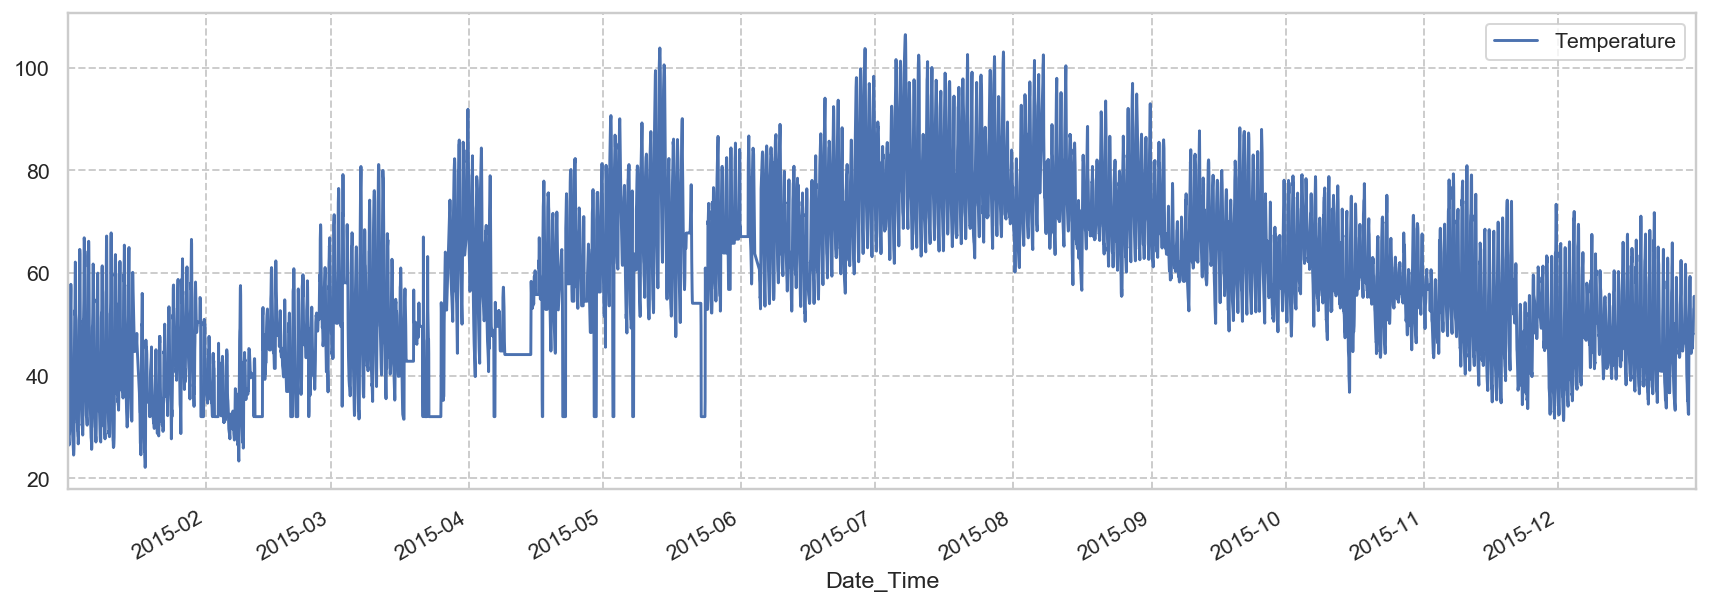

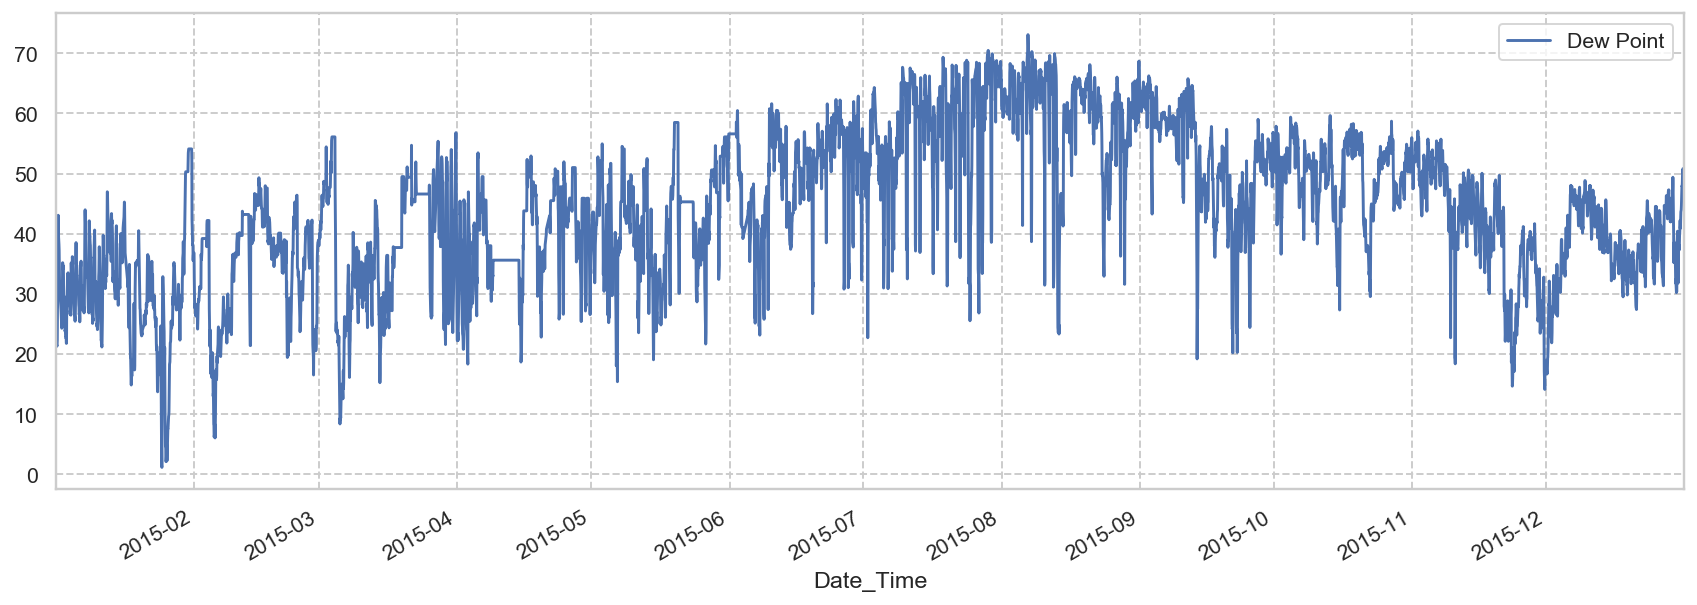

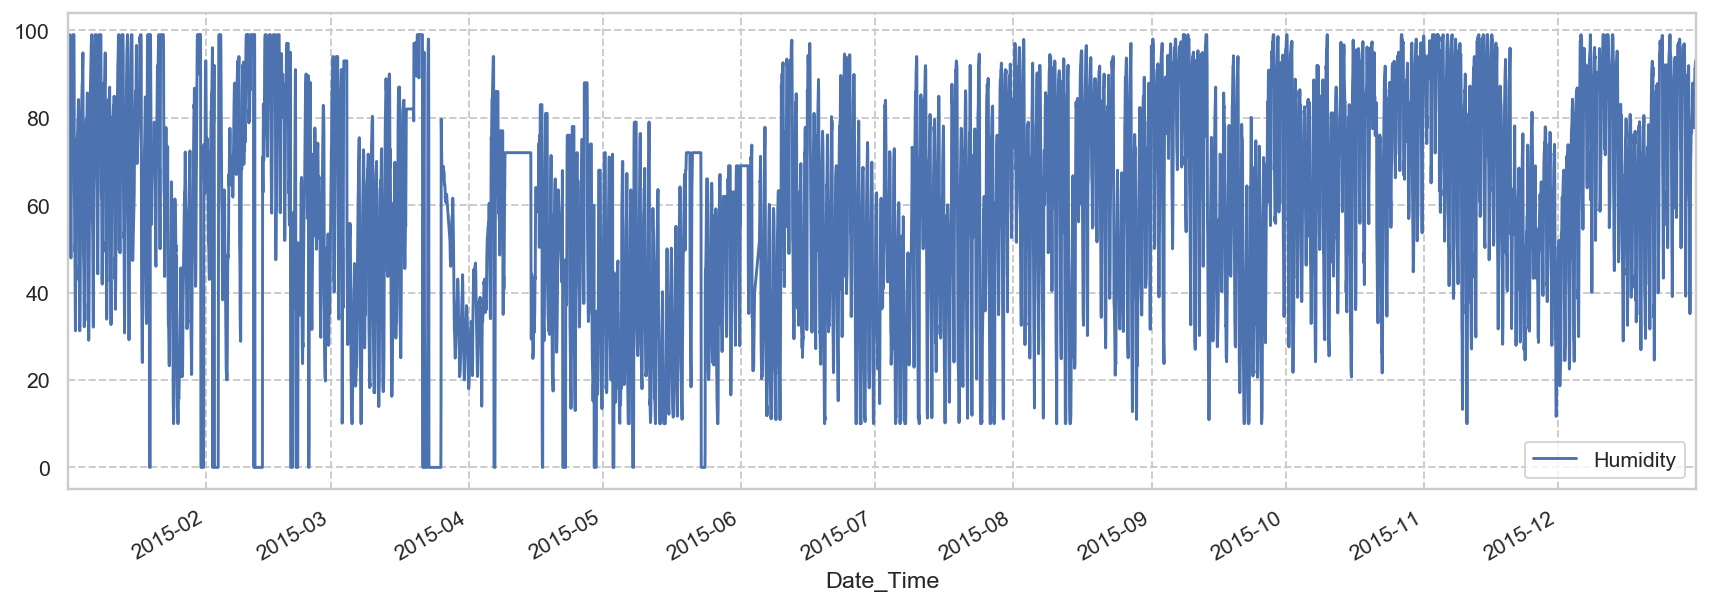

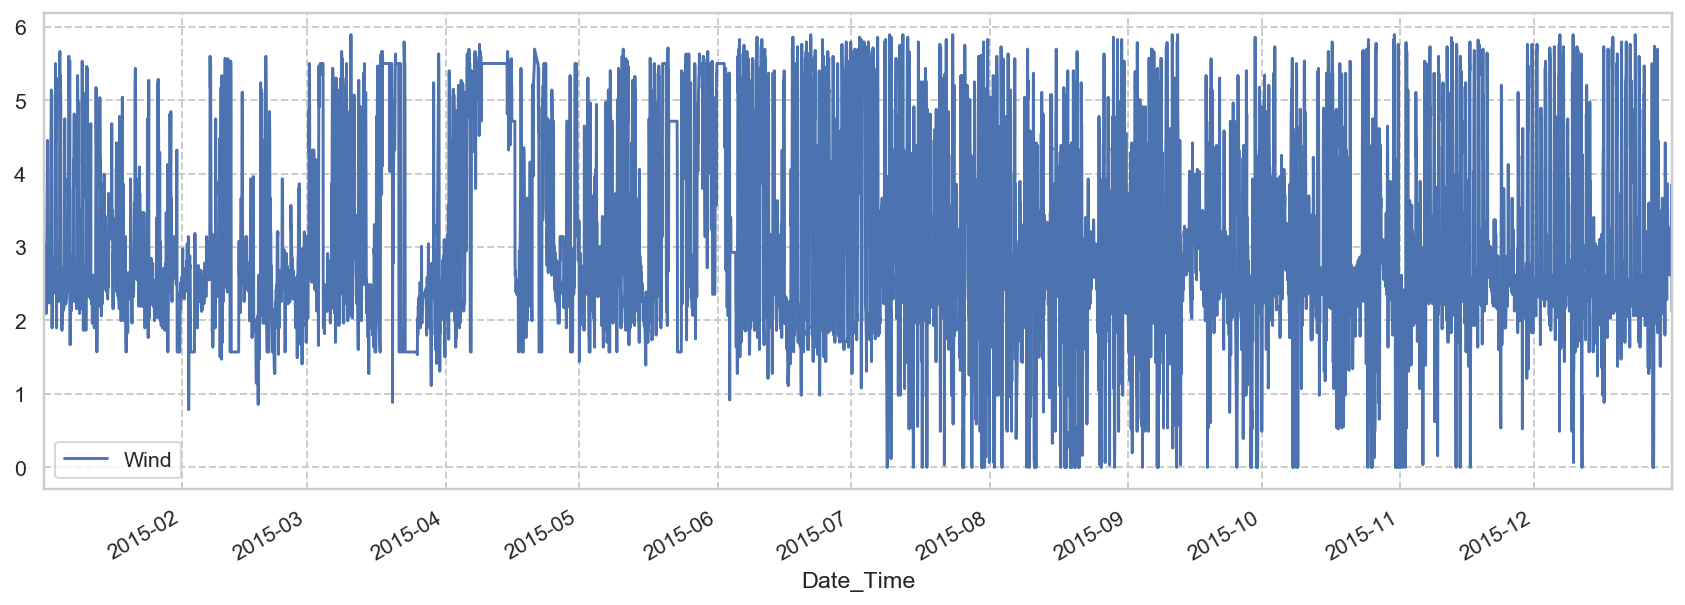

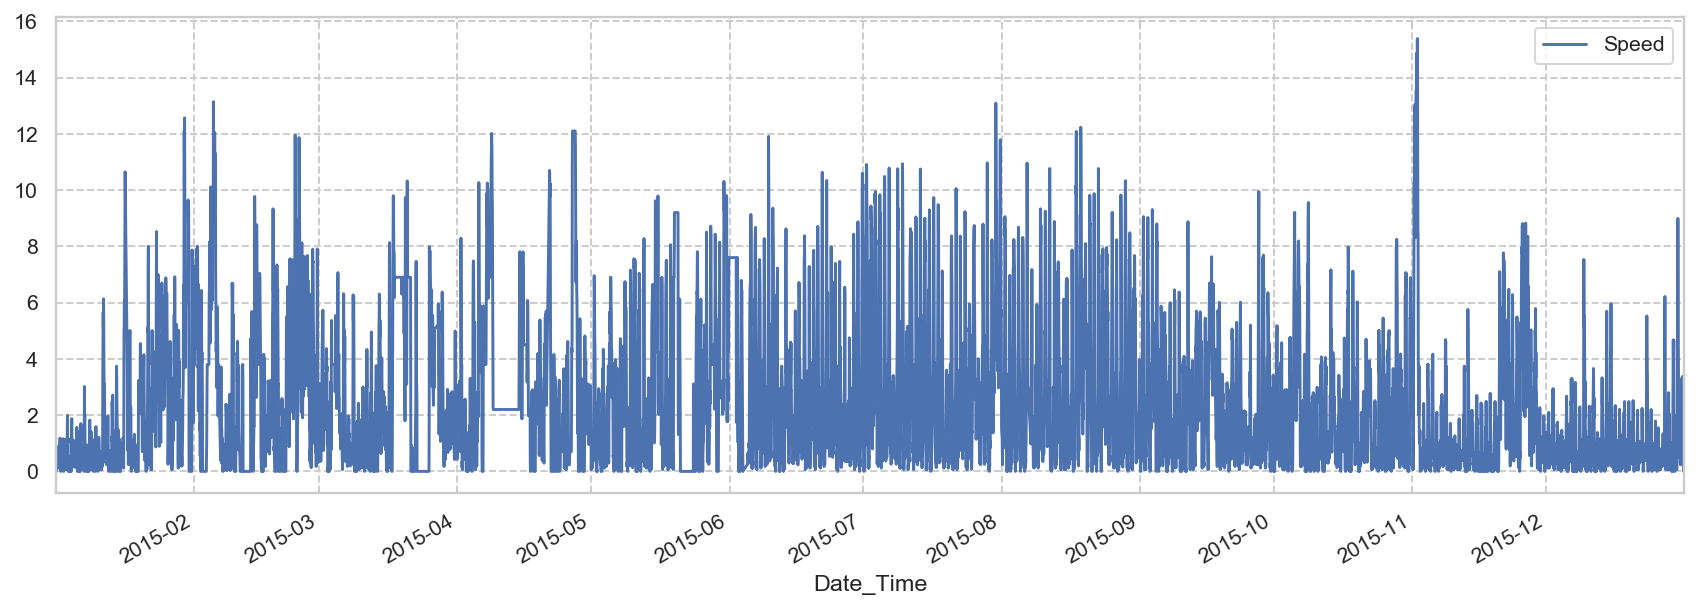

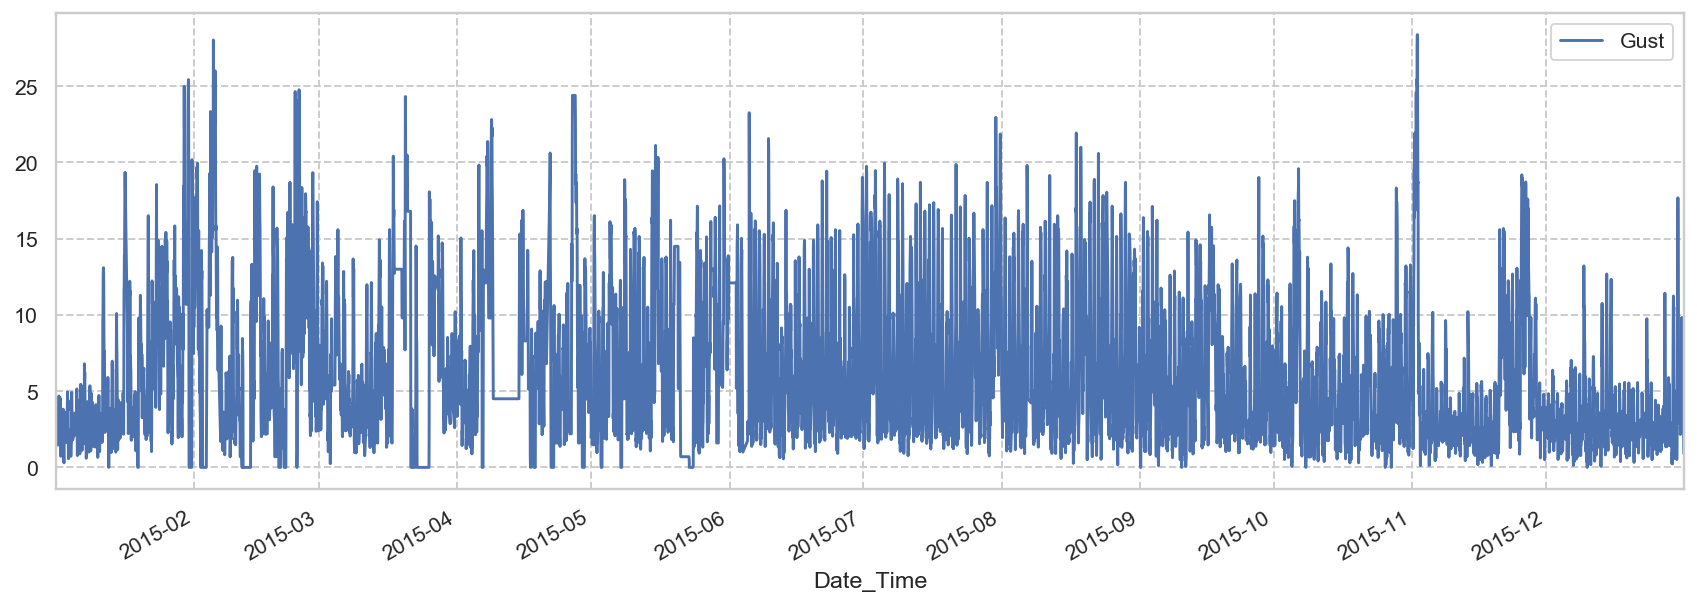

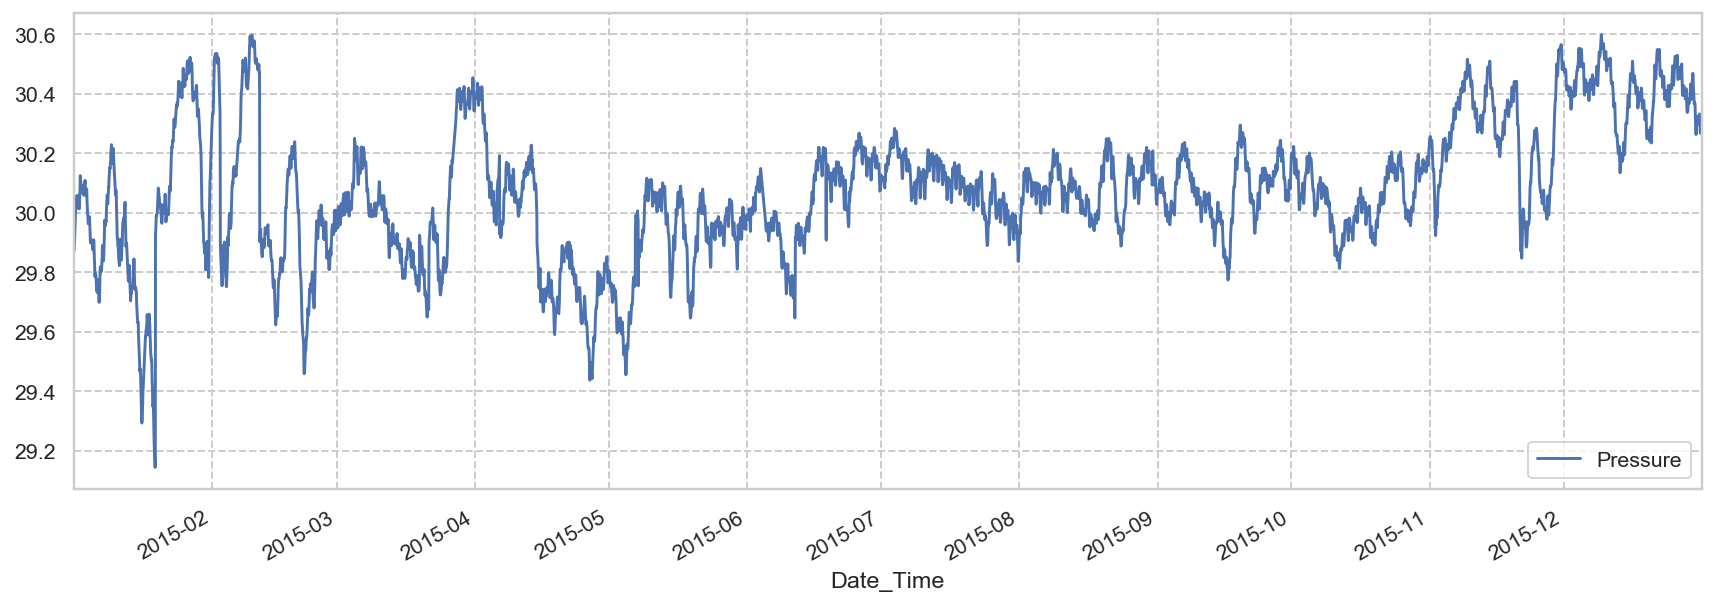

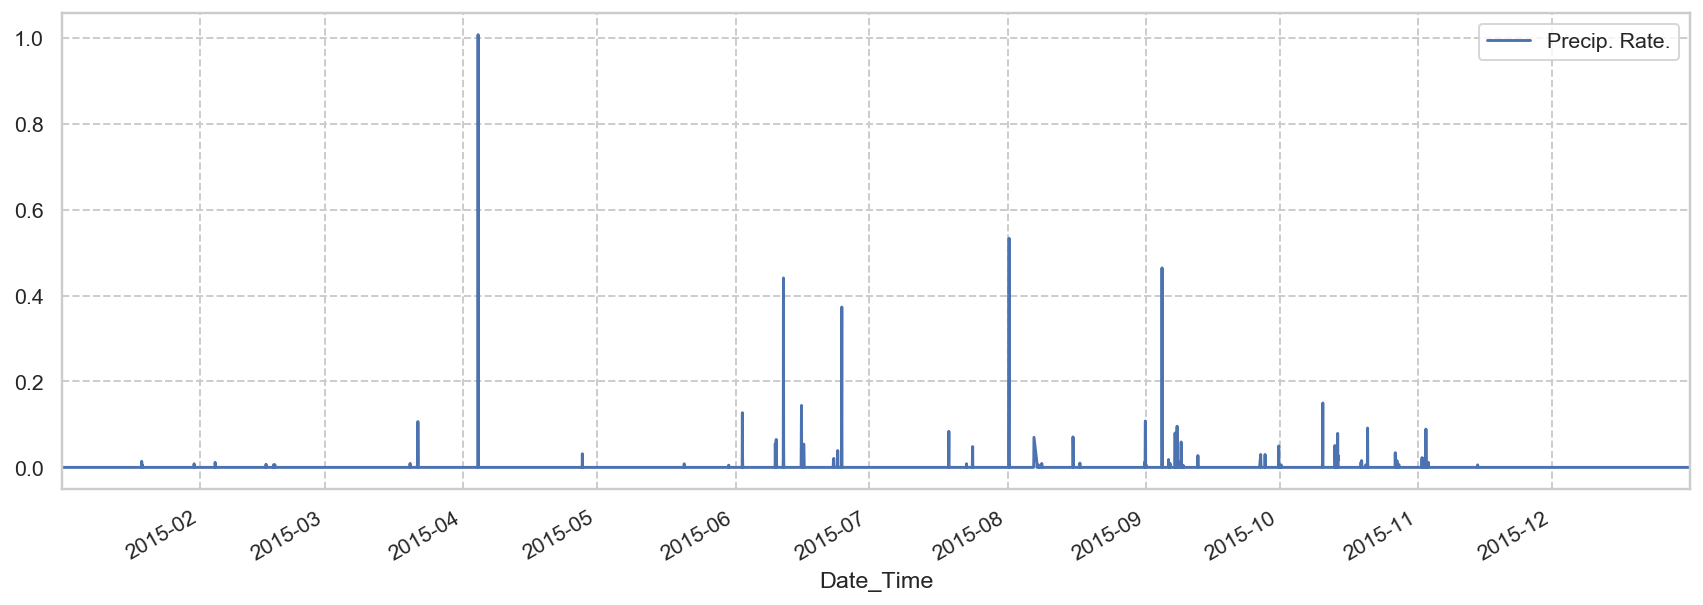

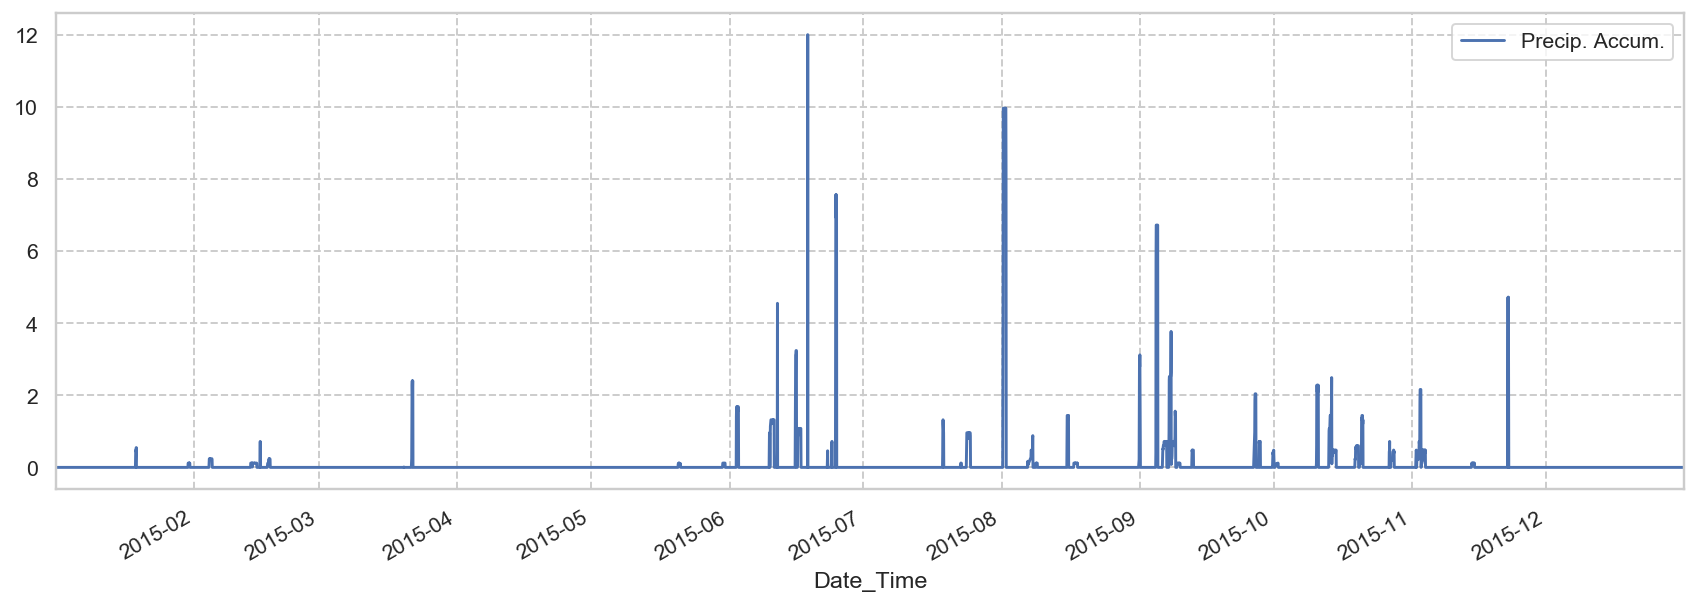

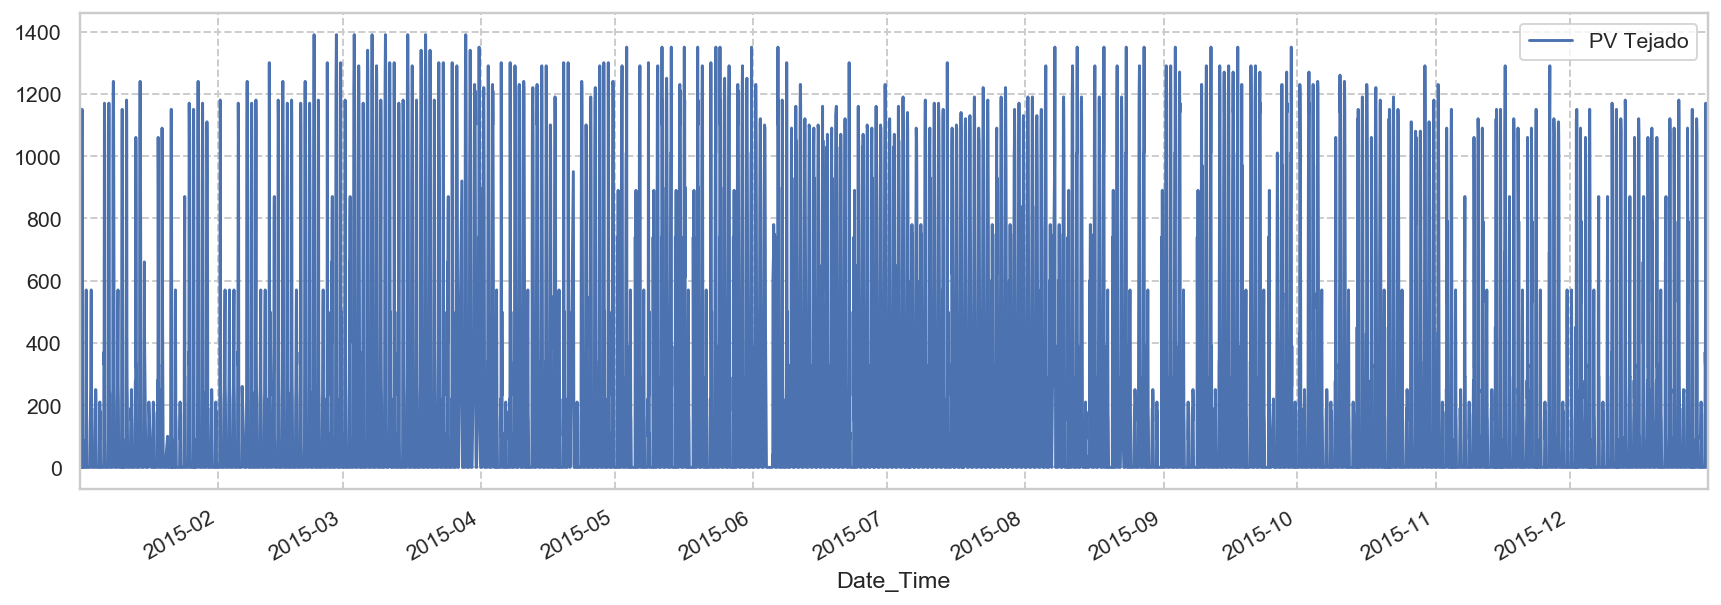

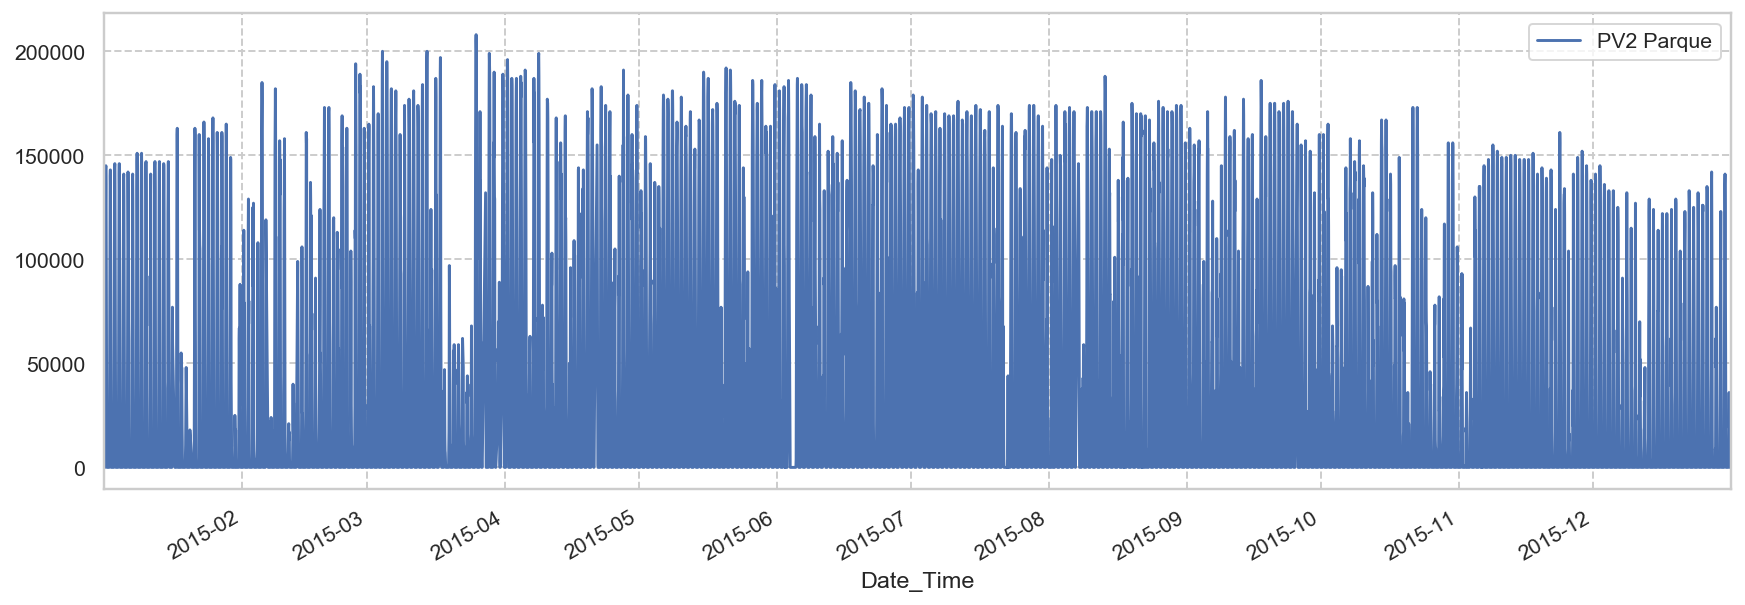

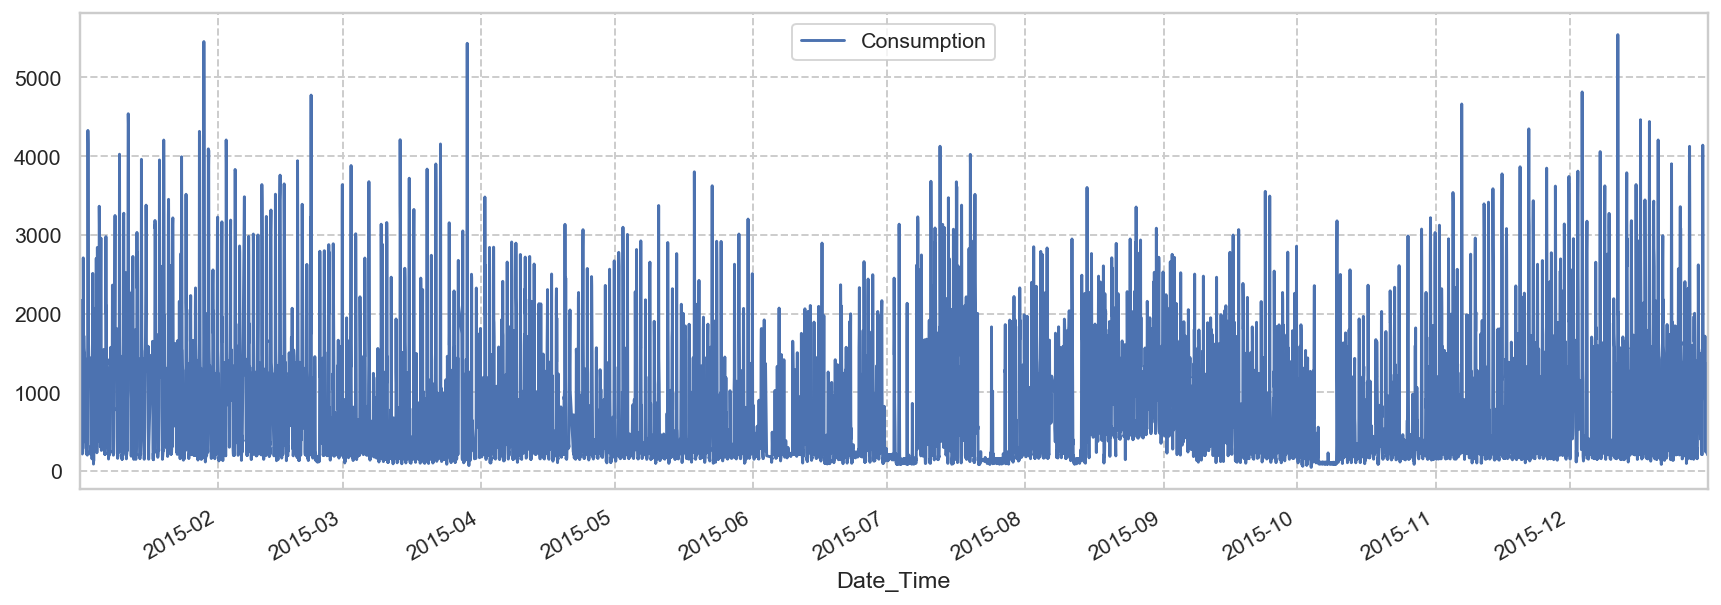

In [8]:
for col in consumption_df.columns:
    consumption_df[col].plot(figsize=(15,5), legend=True)
    plt.show()

## 2. Predicting energy consumption
---

In the following, we will predict the target variable, _Consumption_ using several methods:

* __Simple linear regressors__, using the standard dataset.
* __Simple linear regression models using single-feature auto-regressive data__: the input features are time-shifted versions of the output time series data. We are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive). In this first model, we will only use time_shifted versions of the target variable (and thus we will drop the rest of variables).
* A __Long short-term memory (LSTM) recurrent neural network (RNN) using single-feature auto-regressive data__, with the same lagged target variable dataset as in the previous model is trained on a LSTM RNN.

>_Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDS's (intrusion detection systems)._

### A. Data preparation
---

For each case, we will use the same transformed dataframe: 
1. First, each of ```consumption_df```'s variables is time-shifted 10 times.
2. We set the option of rolling the dataset, computing a moving average depending on whether we want to predict the next $x$ hours. It can be shown that __rolling over a window of 8 to 12 hours gives deviations of only 3%__.
3. The data is then re-scaled using ```MinMaxScaler```. This scaling is later reversed to compute the different metrics.
4. Finally, the resulting dataset, ```reframed``` is split into train and tests sets: __we train over 11 months__ (January to November) and __test on December__.

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Function obtained from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def autorregresive_transformer(data, n_in=1, n_out=1, dropnan=True):
    ''' convert dataframe to an autoregressive model '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### 1. Auto-regressive transformer

In [11]:
values = consumption_df.values
n_features = values.shape[1]

#=======================================================  transform dataframe
auto_df = autorregresive_transformer(values, 10, 1, True)
auto_df.index = consumption_df.index[10:]
auto_df.head()

var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  \
Date_Time                                                             
2015-01-01 12:00:00   29.616667   21.766667   72.250000    3.043418   
2015-01-01 13:00:00   28.025000   21.400000   75.833333    2.814343   
2015-01-01 14:00:00   27.850000   21.516667   76.750000    2.912518   
2015-01-01 15:00:00   27.000000   21.291667   78.666667    2.781618   
2015-01-01 16:00:00   26.925000   21.366667   79.250000    2.225295   

                     var5(t-10)  var6(t-10)  var7(t-10)  var8(t-10)  \
Date_Time                                                             
2015-01-01 12:00:00    0.000000    1.650000   29.873333         0.0   
2015-01-01 13:00:00    0.283333    1.716667   29.884167         0.0   
2015-01-01 14:00:00    0.191667    1.808333   29.900000         0.0   
2015-01-01 15:00:00    0.116667    1.458333   29.916667         0.0   
2015-01-01 16:00:00    0.450000    2.308333   29.930833         0.0   

                     var9(t-10)  var10(t-10)  ...    var3(t)   var4(t)  \
Date_Time                                     ...                        
2015-01-01 12:00:00         0.0          0.0  ...  77.916667  2.258020   
2015-01-01 13:00:00         0.0          0.0  ...  61.500000  2.650719   
2015-01-01 14:00:00         0.0          0.0  ...  61.083333  3.043418   
2015-01-01 15:00:00         0.0          0.0  ...  52.666667  3.534292   
2015-01-01 16:00:00         0.0          0.0  ...  47.916667  3.697916   

                      var5(t)   var6(t)    var7(t)  var8(t)  var9(t)  \
Date_Time                                                              
2015-01-01 12:00:00  0.850000  3.941667  30.055833      0.0      0.0   
2015-01-01 13:00:00  0.358333  3.241667  30.050833      0.0      0.0   
2015-01-01 14:00:00  0.750000  3.633333  30.035000      0.0      0.0   
2015-01-01 15:00:00  0.766667  3.466667  30.028333      0.0      0.0   
2015-01-01 16:00:00  0.883333  4.683333  30.025000      0.0      0.0   

                     var10(t)  var11(t)  var12(t)  
Date_Time                                          
2015-01-01 12:00:00    1150.0  143000.0    1516.0  
2015-01-01 13:00:00    1150.0  145000.0    1274.0  
2015-01-01 14:00:00     900.0  136000.0     216.0  
2015-01-01 15:00:00     460.0   98000.0     474.0  
2015-01-01 16:00:00       0.0   50000.0     280.0  

[5 rows x 132 columns]

In [12]:
print(consumption_df.shape)
auto_df.shape

(8523, 12)


(8513, 132)

#### 2. Rolling and scaling

In [13]:
#=======================================================  rolling

#==================#
rolling_hours = 24 #
#==================#

auto_df_copy = auto_df.copy()
auto_df_rolled = auto_df_copy.rolling(rolling_hours).mean().dropna()

#=======================================================  normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(auto_df_rolled.values)
scaled_df = pd.DataFrame(scaled, columns=auto_df_rolled.columns)

# rename var%(t) columns to their previous name
cols_names = dict(zip(scaled_df.iloc[:,-12:].columns.tolist(), consumption_df.columns.tolist()))
normal_df = scaled_df.iloc[:,-12:].rename(columns=cols_names)

reframed_df = pd.concat([scaled_df.iloc[:, :-12], normal_df], axis=1).dropna()
reframed_df.index = auto_df_rolled.index
reframed_df.describe()

var1(t-10)   var2(t-10)   var3(t-10)   var4(t-10)   var5(t-10)  \
count  8490.000000  8490.000000  8490.000000  8490.000000  8490.000000   
mean      0.499790     0.621664     0.612975     0.504038     0.222597   
std       0.227847     0.185055     0.180344     0.152025     0.144676   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.310268     0.485211     0.488966     0.413939     0.118545   
50%       0.489896     0.625627     0.628615     0.480462     0.199916   
75%       0.687845     0.757569     0.753278     0.551978     0.290670   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        var6(t-10)   var7(t-10)    var8(t-10)    var9(t-10)  var10(t-10)  ...  \
count  8490.000000  8490.000000  8.490000e+03  8.490000e+03  8490.000000  ...   
mean      0.272821     0.594508  1.955592e-02  1.165742e-02     0.303592  ...   
std       0.137092     0.171860  9.061953e-02  5.666661e-02     0.153014  ...   
min       0.000000     0.000000  0.000000e+00  0.000000e+00     0.000000  ...   
25%       0.179098     0.495786  0.000000e+00  3.554935e-18     0.179744  ...   
50%       0.253521     0.590340  1.721810e-18  4.333635e-17     0.314969  ...   
75%       0.328858     0.679566  1.635719e-17  4.116953e-16     0.437952  ...   
max       1.000000     1.000000  1.000000e+00  1.000000e+00     1.000000  ...   

          Humidity         Wind        Speed         Gust     Pressure  \
count  8490.000000  8490.000000  8490.000000  8490.000000  8490.000000   
mean      0.612966     0.504101     0.222720     0.272944     0.594776   
std       0.180336     0.152006     0.144567     0.137006     0.171969   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.488966     0.413939     0.118670     0.179320     0.495786   
50%       0.628615     0.480673     0.199916     0.253549     0.590738   
75%       0.753247     0.551978     0.290670     0.328858     0.680014   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       Precip. Rate.  Precip. Accum.    PV Tejado   PV2 Parque  Consumption  
count   8.490000e+03    8.490000e+03  8490.000000  8490.000000  8490.000000  
mean    1.955592e-02    1.165742e-02     0.303551     0.354029     0.368128  
std     9.061953e-02    5.666661e-02     0.153023     0.140428     0.165826  
min     0.000000e+00    0.000000e+00     0.000000     0.000000     0.000000  
25%     0.000000e+00    3.554935e-18     0.179744     0.258496     0.254055  
50%     1.721810e-18    4.333635e-17     0.314969     0.356243     0.357751  
75%     1.635719e-17    4.116953e-16     0.437952     0.474990     0.474454  
max     1.000000e+00    1.000000e+00     1.000000     1.000000     1.000000  

[8 rows x 132 columns]

#### 3. Train/test split

In [14]:
reframed_train  = reframed_df.loc[:'2015-11']
reframed_test = reframed_df.loc['2015-12':]

### B. Multi-feature linear regression

First, we try a simple liear regressor using the standard dataset with no lagged features. We fit the model and visualize it's coefficients.

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE, r2_score

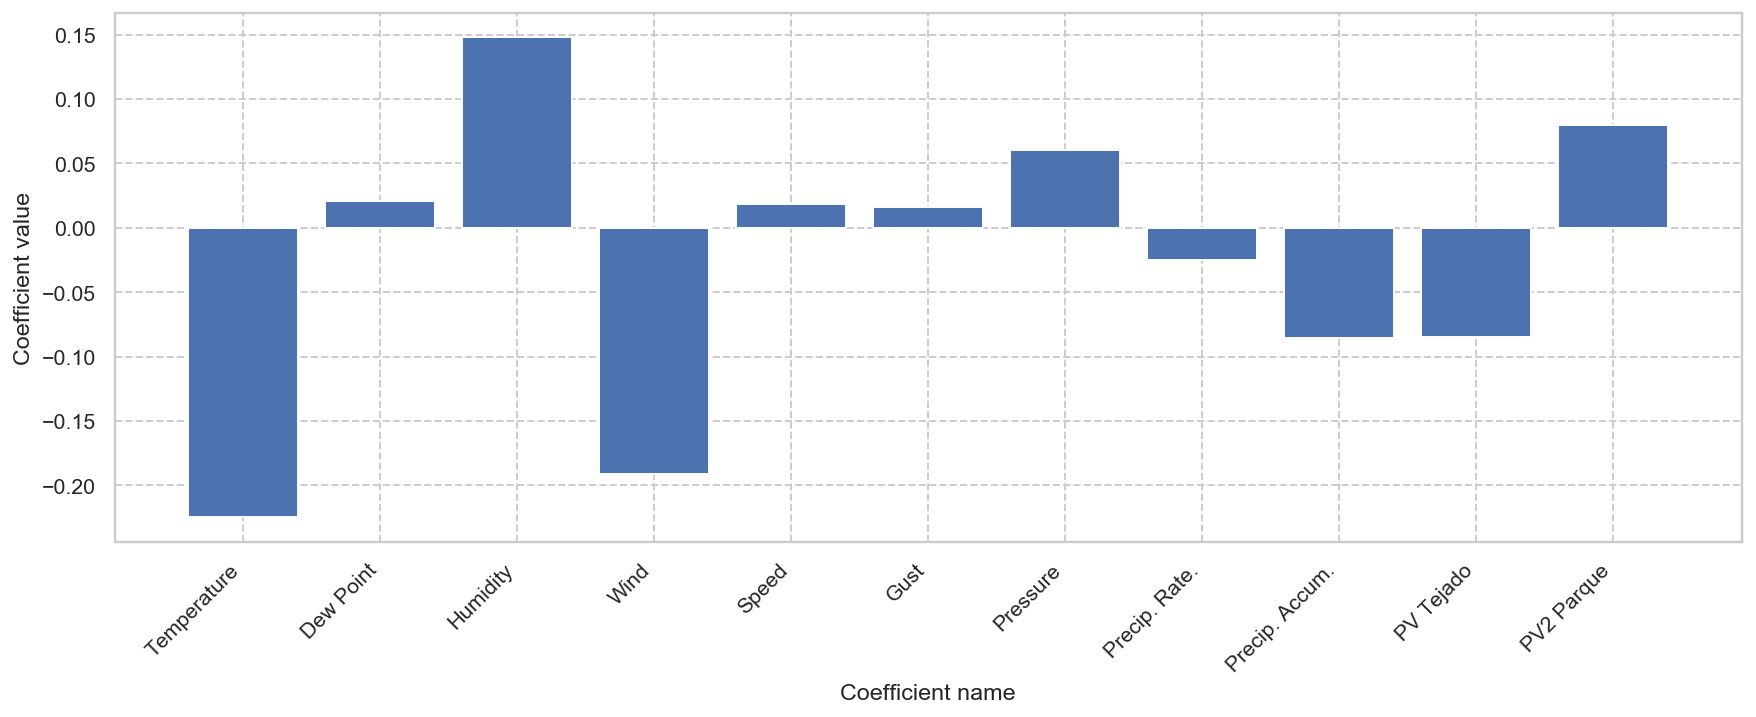

In [16]:
X_train, y_train = reframed_train.copy().iloc[:,-12:-1], reframed_train.copy().iloc[:,-1]
X_test, y_test = reframed_test.copy().iloc[:,-12:-1], reframed_test.copy().iloc[:,-1]

#=======================================================  Fit the model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

#=======================================================  Show coefficients
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax


# Run the function to visualize model's coefficients
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
visualize_coefficients(model_1.coef_, X_train.columns, ax=axs)
plt.show()

Large absolute values of coefficients mean that a given feature has a large impact on the output variable. When we use time-lagged features on the data, we see that the highest coefficient by far is the first one. This means that the $N-1$th time point (and maybe the next one) is useful in predicting the $N$th timepoint, but no other points are useful.

#### 1. Performance

Here we calculate the [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), the [model accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and the [mean directional accuracy](https://en.wikipedia.org/wiki/Mean_directional_accuracy).

Remember that we first revert the scaling, so the numbers are on the initial datasets units.

In [17]:
#=======================================================  predict on test set
y_pred = model_1.predict(X_test)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]


y_pred_model_1 = inverting(y_pred.reshape(y_pred.shape[0],1))
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#=======================================================  metrics

# calculate RMSE
rmse_model_1 = sqrt(MSE(y_inv, y_pred_model_1))
print('Test RMSE: %.3f' % rmse_model_1)

# calculate model accuracy
accuracy_model_1 = r2_score(y_inv, y_pred_model_1)
print('Model accuracy: {:.3f}'.format(accuracy_model_1))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

mda_model_1 = mda(y_inv, y_pred_model_1)
print('Model Mean Directional accuracy: {:.3f}'.format(mda_model_1))

Test RMSE: 231.809
Model accuracy: -0.257
Model Mean Directional accuracy: 0.536


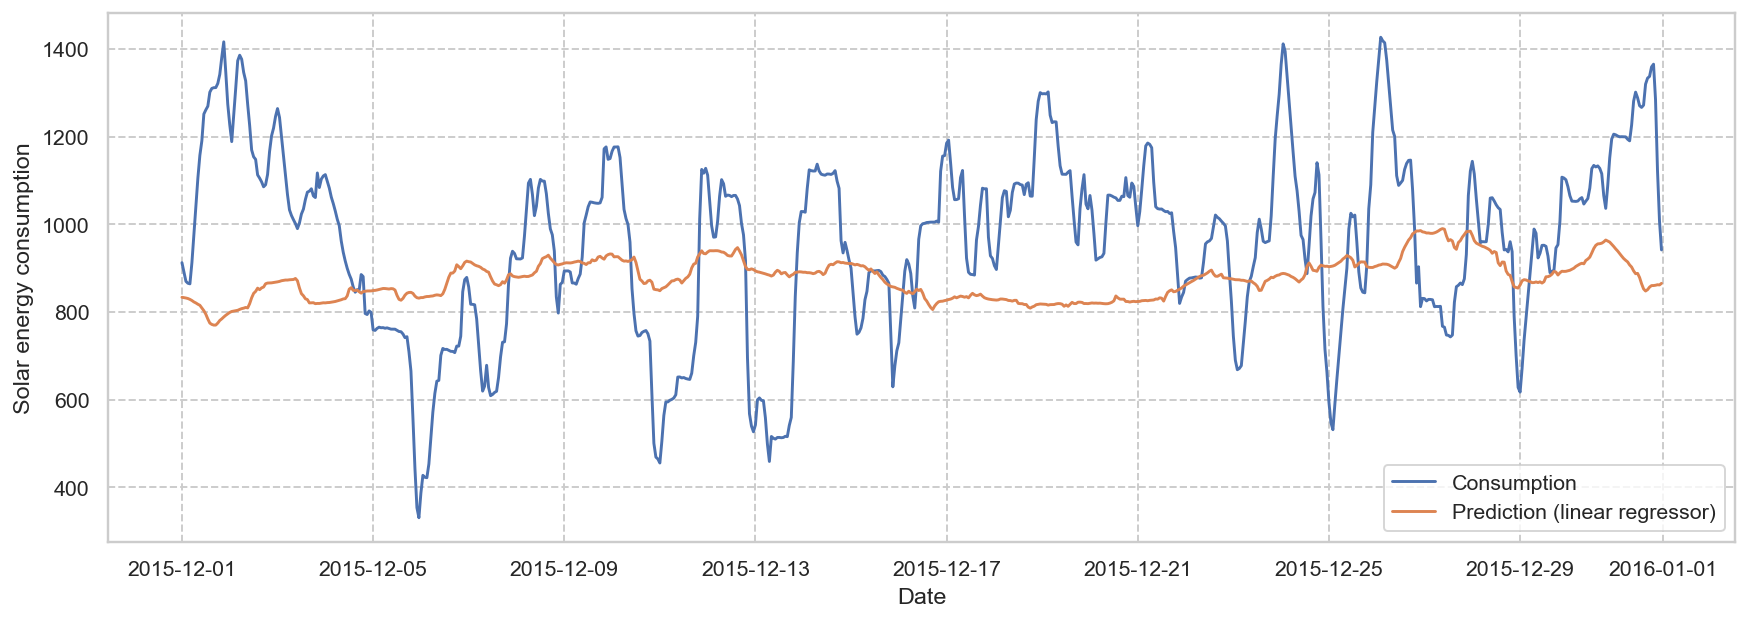

In [18]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_model_1, label='Prediction (linear regressor)')
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.legend()
plt.show()

### C. Single-feature, auto-regressive linear regression
---

Now, we study a model of a linear regressor using a lagged dataset of the target value. For this, we take our transformed ```reframed_train``` dataset and select only the columns corresponding to _var12_ (the lagged versions of the target variable _Consumption_). 

The dataset to use is called ```consumption_auto_df```. The test version given by ```consumption_auto_df_test```.

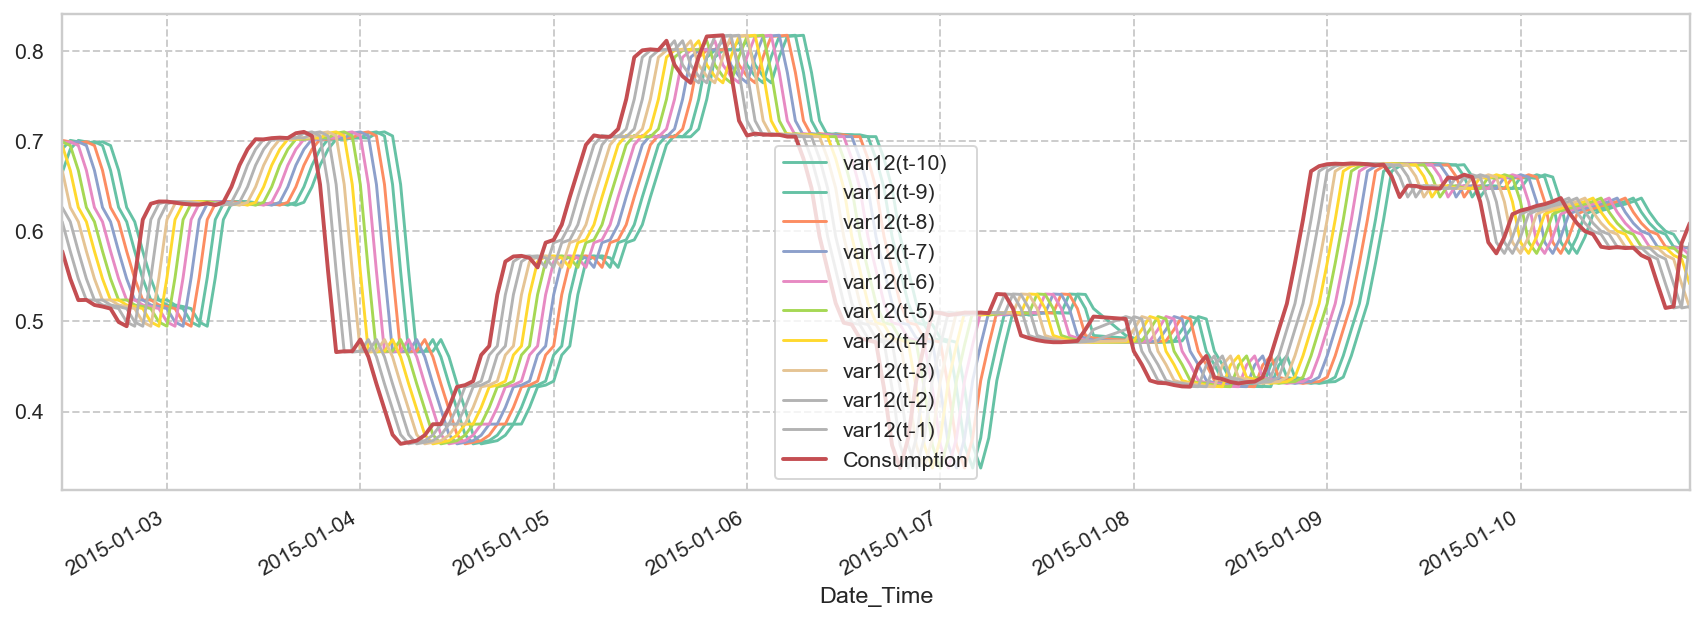

In [19]:
#=======================================================  Simple auto-regressive (lagged target)
consumption_auto_df = reframed_train.copy()
consumption_auto_df = consumption_auto_df.iloc[:, 11::12]

consumption_auto_df_test = reframed_test.copy()
consumption_auto_df_test = consumption_auto_df_test.iloc[:, 11::12]

# Show the first 200 points
ax = consumption_auto_df.iloc[:200,:-1].plot(cmap=plt.cm.Set2, figsize=(15,5))
consumption_auto_df.iloc[:200,-1].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

#### 1. Fit

We fit a ```LinearRegression``` model and visualize its coefficients.

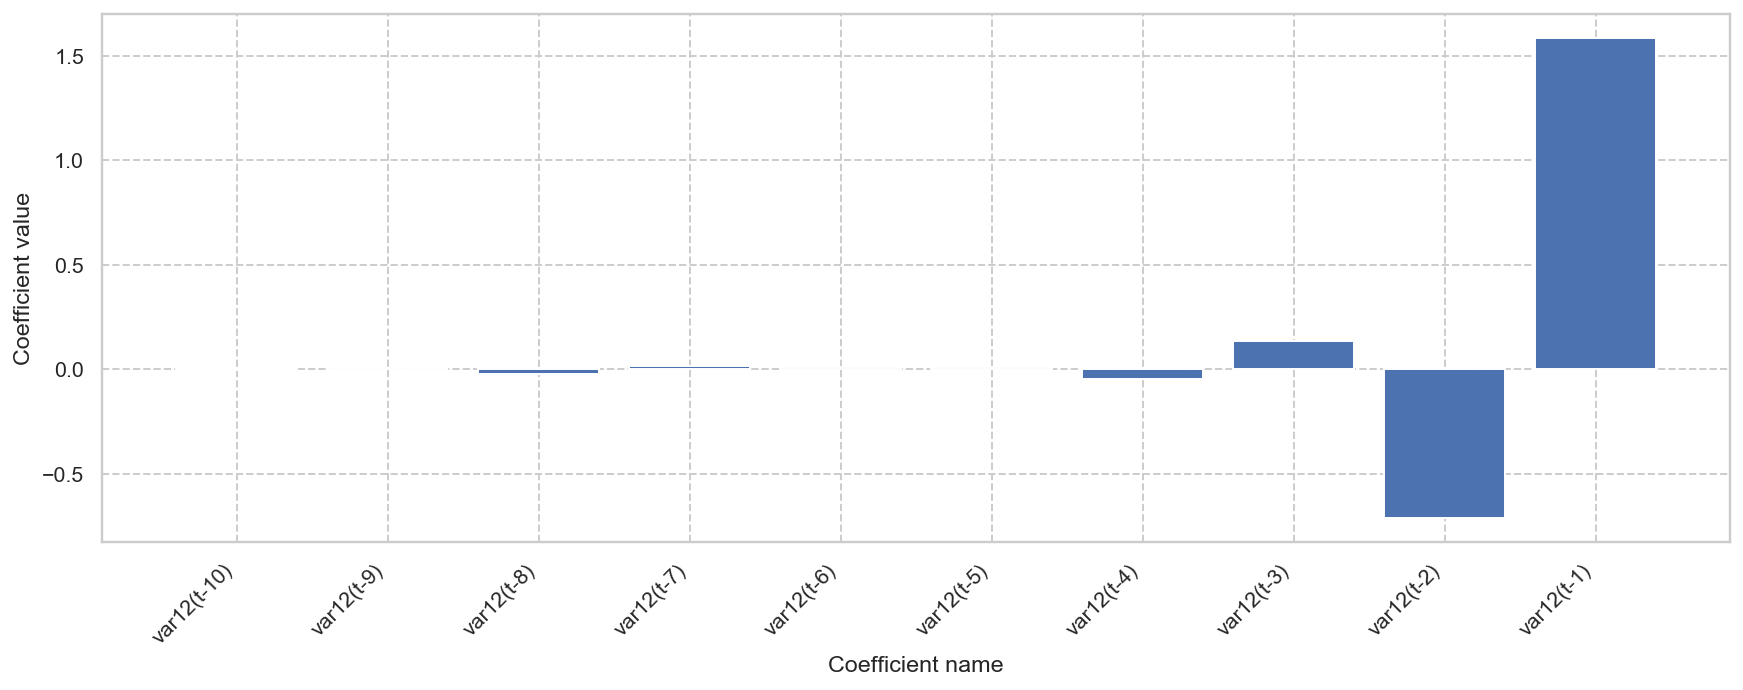

In [20]:
X_train, y_train = consumption_auto_df.iloc[:,:-1], consumption_auto_df.iloc[:,-1]
X_test, y_test = consumption_auto_df_test.iloc[:,:-1], consumption_auto_df_test.iloc[:,-1]

#=======================================================  Fit the model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)

#=======================================================  Show coefficients
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax


# Run the function to visualize model's coefficients
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
visualize_coefficients(model_2.coef_, consumption_auto_df.columns[:-1], ax=axs)
plt.show()

#### 2. Cross-validation

To have an overall understanding of this model's performance, we use a cross-validation object: ```TimeSeriesSplit```. This object always uses data from the past to predict timepoints in the future. Through CV iterations, a larger amount of training data is used to predict the next block of validation data, corresponding to the fact that more time has passed. This more closely mimics the data collection and predictions process in the real world. 

In the following plots we see how the ```TimeSeriesSplit``` CV object behaves––we iterate through the object and plot the training data in blue and the validation data in red. Each row is an iteration of the cross-validation. In red we see the indices for that iteration. As one can see, the training data always comes before the validation data. This ensures that only the past is always used to predict the future.

In [21]:
# Function to visualize predictions from the CV object obtained from DataCamp
def visualize_predictions(results):
    fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs.scatter(indices, prediction,
                       alpha=0.5, s=4, label='Iteration {}'.format(ii))
        
    axs.legend(loc="best")
    axs.set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    # plt.savefig('plot.png')
    plt.show()

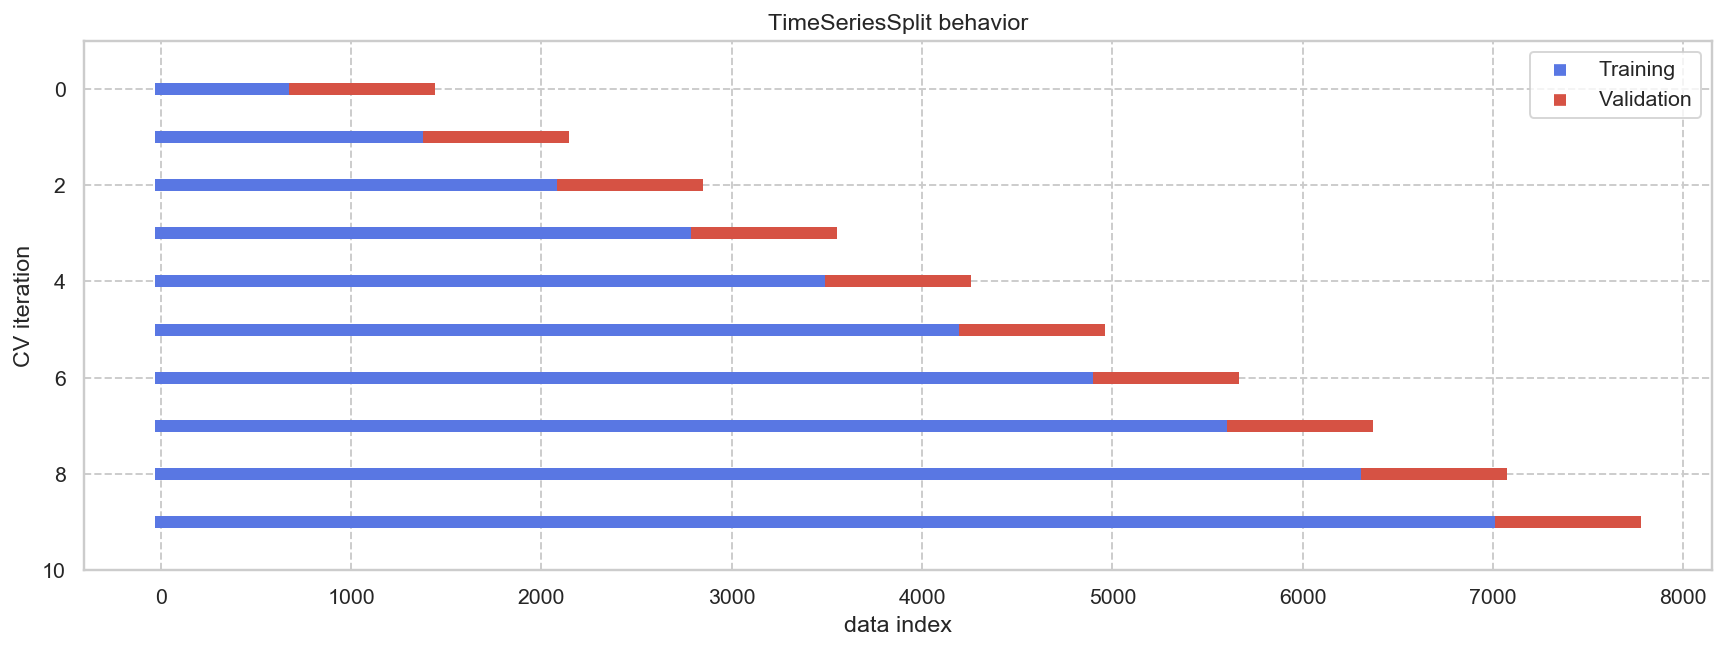

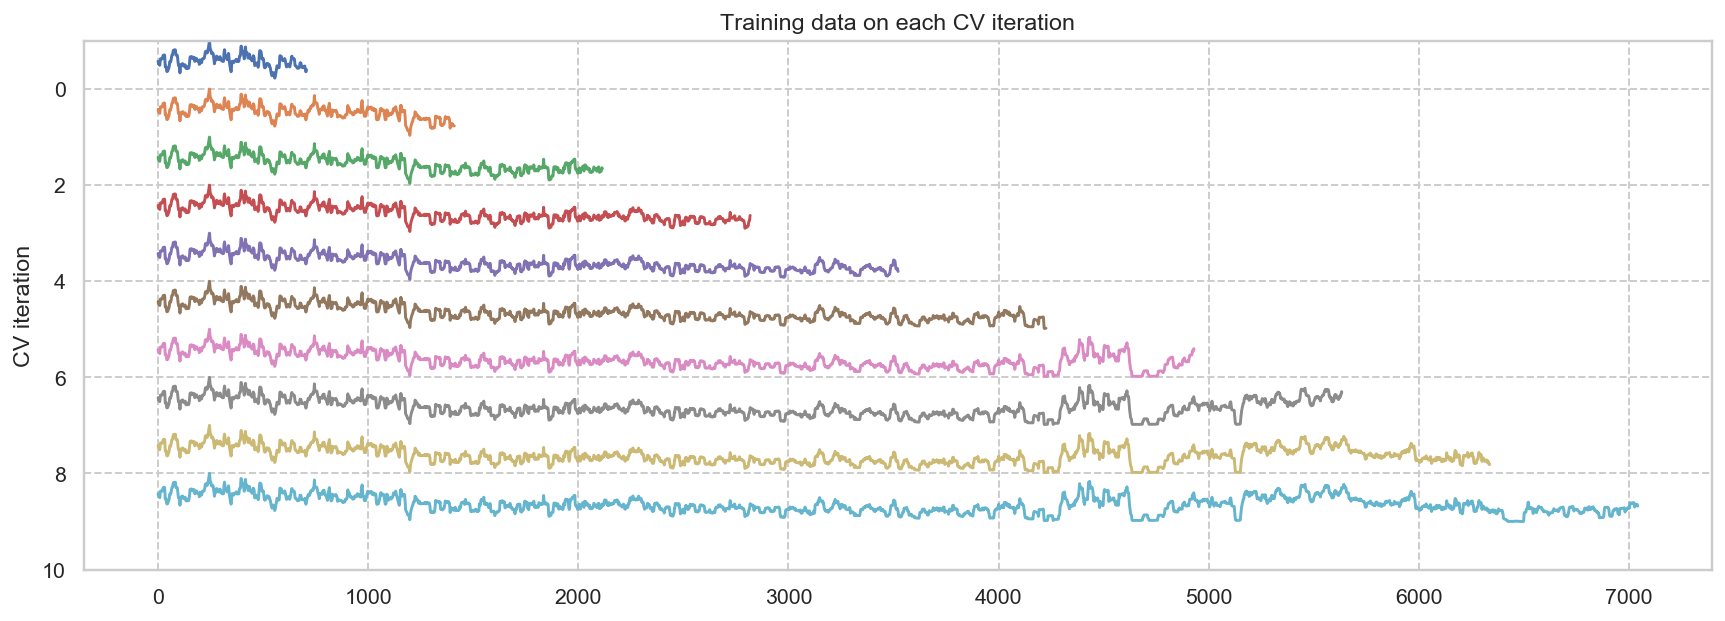

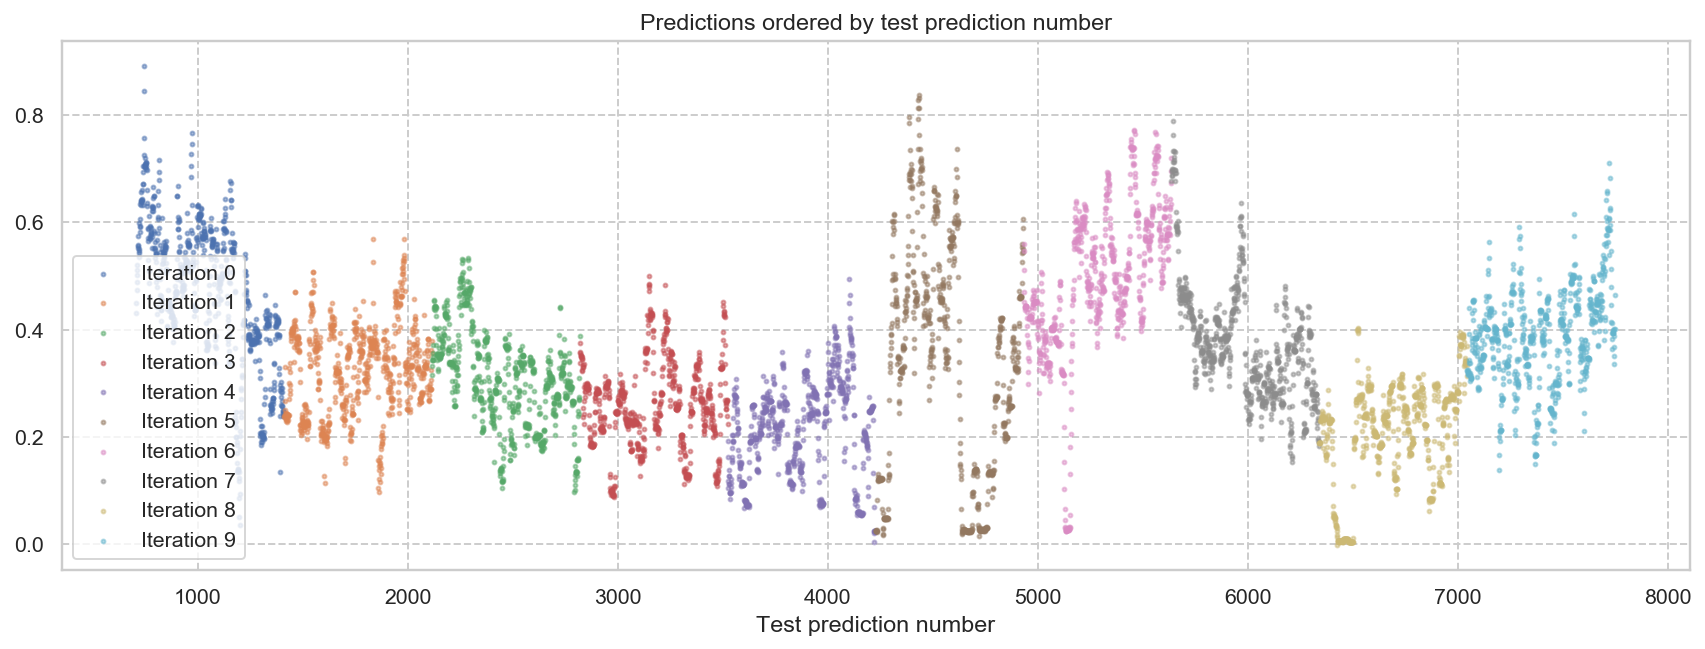

In [22]:
# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

#=======================================================  CV behavior
# Plot CV behavior
fig, ax = plt.subplots(figsize=(15, 5))
for ii, (tr, tt) in enumerate(cv.split(X_train, y_train)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

# Plot training sets for each CV split
fig, ax = plt.subplots(figsize=(15,5))
for ii, (tr, tt) in enumerate(cv.split(X_train, y_train)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii - y_train[tr])
ax.set(ylim=[10, -1], title='Training data on each CV iteration', ylabel='CV iteration')

#=======================================================  CV predictions
# Iterate through CV splits
results_ts = []

for tr, tt in cv.split(X_train.values, y_train):
    # Fit the model on training data
    model_2.fit(X_train.values[tr], y_train[tr])
    
    # Generate predictions on the test data and collect
    prediction = model_2.predict(X_train.values[tt])
    score = r2_score(y_train[tt], prediction)
    results_ts.append((prediction, score, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results_ts)

plt.show()

#### 3. Performance

In [23]:
#=======================================================  cross-validation mean score
print('TimeSeriesSplit CV mean score: {}'.format(round(np.mean([results_ts[i][1] 
                                                                for i in range(len(results_ts))]),2)))

#=======================================================  predict on test set
y_pred = model_2.predict(X_test)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]


y_pred_model_2 = inverting(y_pred.reshape(y_pred.shape[0],1))
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#=======================================================  metrics

# calculate RMSE
rmse_model_2 = sqrt(MSE(y_inv, y_pred_model_2))
print('Test RMSE: %.3f' % rmse_model_2)

# calculate model accuracy
accuracy_model_2 = r2_score(y_inv, y_pred_model_2)
print('Model accuracy: {:.3f}'.format(accuracy_model_2))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

mda_model_2 = mda(y_inv, y_pred_model_1)
print('Model Mean Directional accuracy: {:.3f}'.format(mda_model_2))

TimeSeriesSplit CV mean score: 0.98
Test RMSE: 33.636
Model accuracy: 0.974
Model Mean Directional accuracy: 0.536


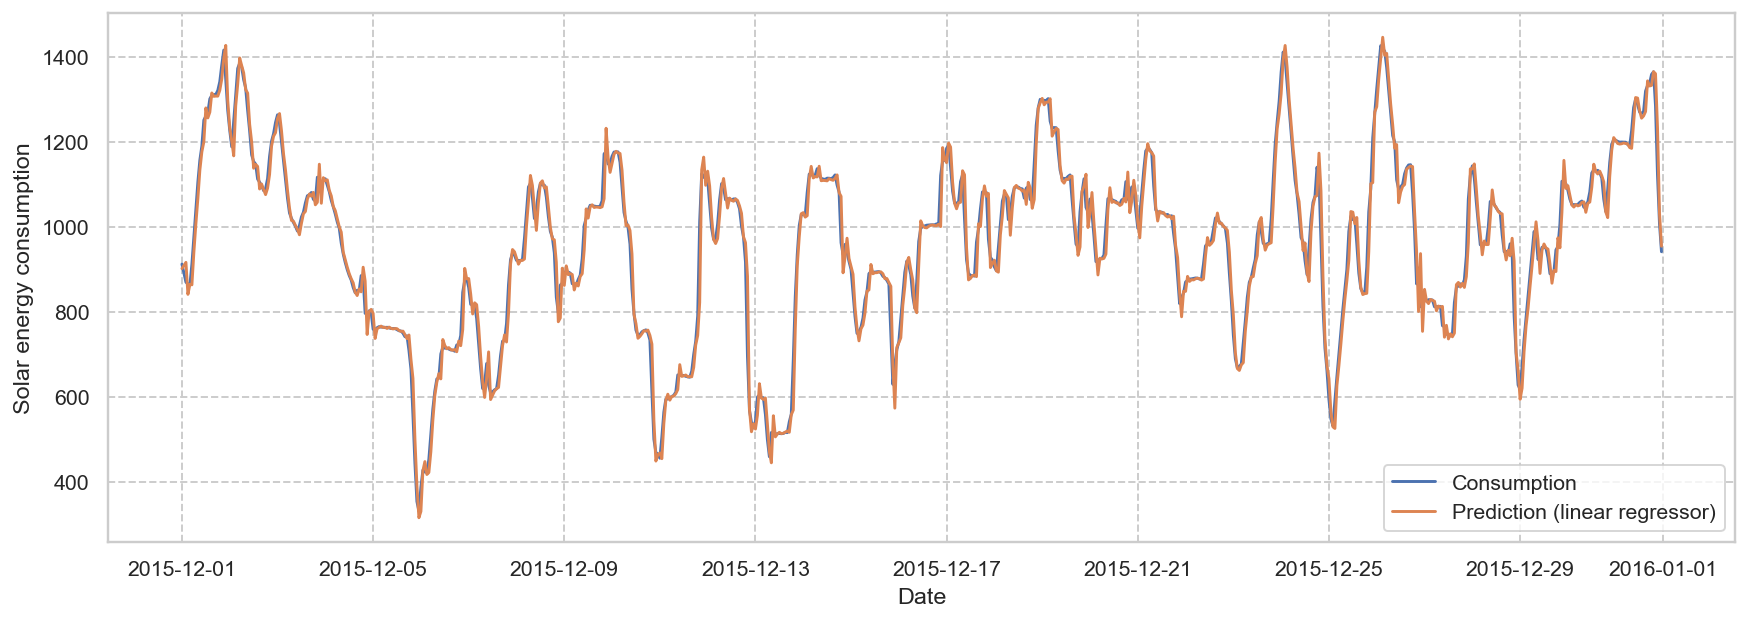

In [24]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_model_2, label='Prediction (linear regressor)')
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.legend()
plt.show()

### D. Single-feature, auto-regressive long short-term memory (LSTM) recurrent neural network (RNN)
---

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


To use keras's LSTM layers, we need to reshape the input data in the form of [samples, timesteps, features]. Also, we use the same train and test sets from the previous model, however we now hold data from Noverber to be used as validation set.

In [26]:
X_train_lstm, y_train_lstm = X_train[:'2015-10'], y_train[:'2015-10']
X_val, y_val = X_train['2015-11':], y_train['2015-11':]

# For LSTM, the imput shape is in the form of (samples, timesteps, features)
X_train_shape = (X_train_lstm.shape[0], 10, 1)
X_val_shape = (X_val.shape[0], 10, 1)
X_test_shape = (X_test.shape[0], 10, 1)

# reshape input to be 3D [samples, timesteps, features]
X_train_in = X_train_lstm.values.reshape(X_train_shape)
X_val_in = X_val.values.reshape(X_val_shape)
X_test_in = X_test.values.reshape(X_test_shape)
print('X_train_lstm:', X_train_lstm.shape, 'y_train_lstm:', y_train_lstm.shape, 
      '\nX_train_in:', X_train_in.shape, 
      '\nX_val_in:', X_val_in.shape, 'y_val:', y_val.shape,
      '\nX_test_in:', X_test_in.shape, 'X_test:', y_test.shape)

X_train_lstm: (7032, 10) y_train_lstm: (7032,) 
X_train_in: (7032, 10, 1) 
X_val_in: (715, 10, 1) y_val: (715,) 
X_test_in: (743, 10, 1) X_test: (743,)


#### 1. Fit

We build a sequential network of an imput LSTM layer with 50 neurons and a dense output layer, with a [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) loss metric, and the [Adam](https://arxiv.org/abs/1412.6980) optimizer. 

We then fit it over 100 epochs with ```EarlyStopping```, and validate with the validation set (November).

In [27]:
def fit_network(n_neurons=50, batch_size=72, epochs=100, optimizer='adam', verbosity=2):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train_in.shape[1], X_train_in.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    # Run network
    history = model.fit(X_train_in, y_train_lstm, epochs=epochs, batch_size=batch_size, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                        validation_data=(X_val_in, y_val), shuffle=False,
                        verbose=verbosity)
    
    return (model, history)

model_lstm, history = fit_network(verbosity=2)

Train on 7032 samples, validate on 715 samples
Epoch 1/100
 - 1s - loss: 0.1059 - mse: 0.0343 - val_loss: 0.0578 - val_mse: 0.0051
Epoch 2/100
 - 1s - loss: 0.0402 - mse: 0.0030 - val_loss: 0.0362 - val_mse: 0.0026
Epoch 3/100
 - 1s - loss: 0.0347 - mse: 0.0024 - val_loss: 0.0371 - val_mse: 0.0026
Epoch 4/100
 - 1s - loss: 0.0317 - mse: 0.0021 - val_loss: 0.0318 - val_mse: 0.0021
Epoch 5/100
 - 1s - loss: 0.0268 - mse: 0.0016 - val_loss: 0.0297 - val_mse: 0.0017
Epoch 6/100
 - 1s - loss: 0.0251 - mse: 0.0013 - val_loss: 0.0289 - val_mse: 0.0016
Epoch 7/100
 - 1s - loss: 0.0265 - mse: 0.0014 - val_loss: 0.0297 - val_mse: 0.0016
Epoch 8/100
 - 1s - loss: 0.0247 - mse: 0.0012 - val_loss: 0.0293 - val_mse: 0.0015
Epoch 9/100
 - 1s - loss: 0.0234 - mse: 0.0011 - val_loss: 0.0276 - val_mse: 0.0014
Epoch 10/100
 - 1s - loss: 0.0217 - mse: 9.9423e-04 - val_loss: 0.0262 - val_mse: 0.0013
Epoch 11/100
 - 1s - loss: 0.0212 - mse: 9.2888e-04 - val_loss: 0.0244 - val_mse: 0.0011
Epoch 12/100
 - 1s 

Test loss: 0.012962422848830795
Test mean squared error: 0.0003699415537994355


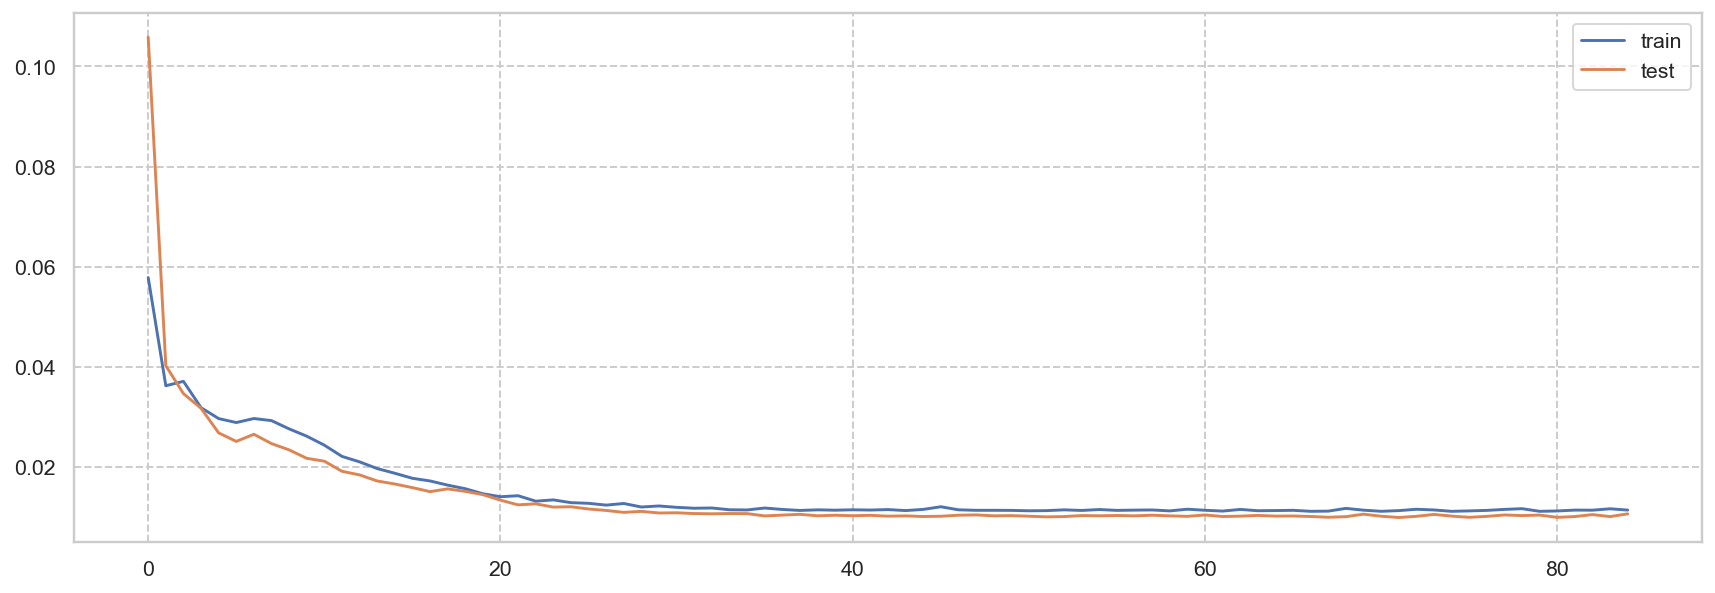

In [28]:
loss, mse = model_lstm.evaluate(X_test_in, y_test, verbose=0)
print('Test loss:', loss)
print('Test mean squared error:', mse)

# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['val_loss'], label='train')
plt.plot(history.history['loss'], label='test')
plt.legend()
plt.show()

#### 2. Performance

In [29]:
y_pred_out = model_lstm.predict(X_test_in)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]

y_pred_lstm_D = inverting(y_pred_out)
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#======================================================= metrics
# calculate RMSE
rmse_lstm = sqrt(MSE(y_inv, y_pred_lstm_D))
print('Test RMSE: %.3f' % rmse_lstm)

# calculate model accuracy
accuracy_lstm = r2_score(y_inv, y_pred_lstm_D)
print('Model accuracy: {:.3f}'.format(accuracy_lstm))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) 
                    == np.sign(predicted[1:] - predicted[:-1])).astype(int))
mda_lstm = mda(y_inv, y_pred_lstm_D)

print('Model Mean Directional accuracy: {:.3f}'.format(mda_lstm))

Test RMSE: 34.195
Model accuracy: 0.973
Model Mean Directional accuracy: 0.702


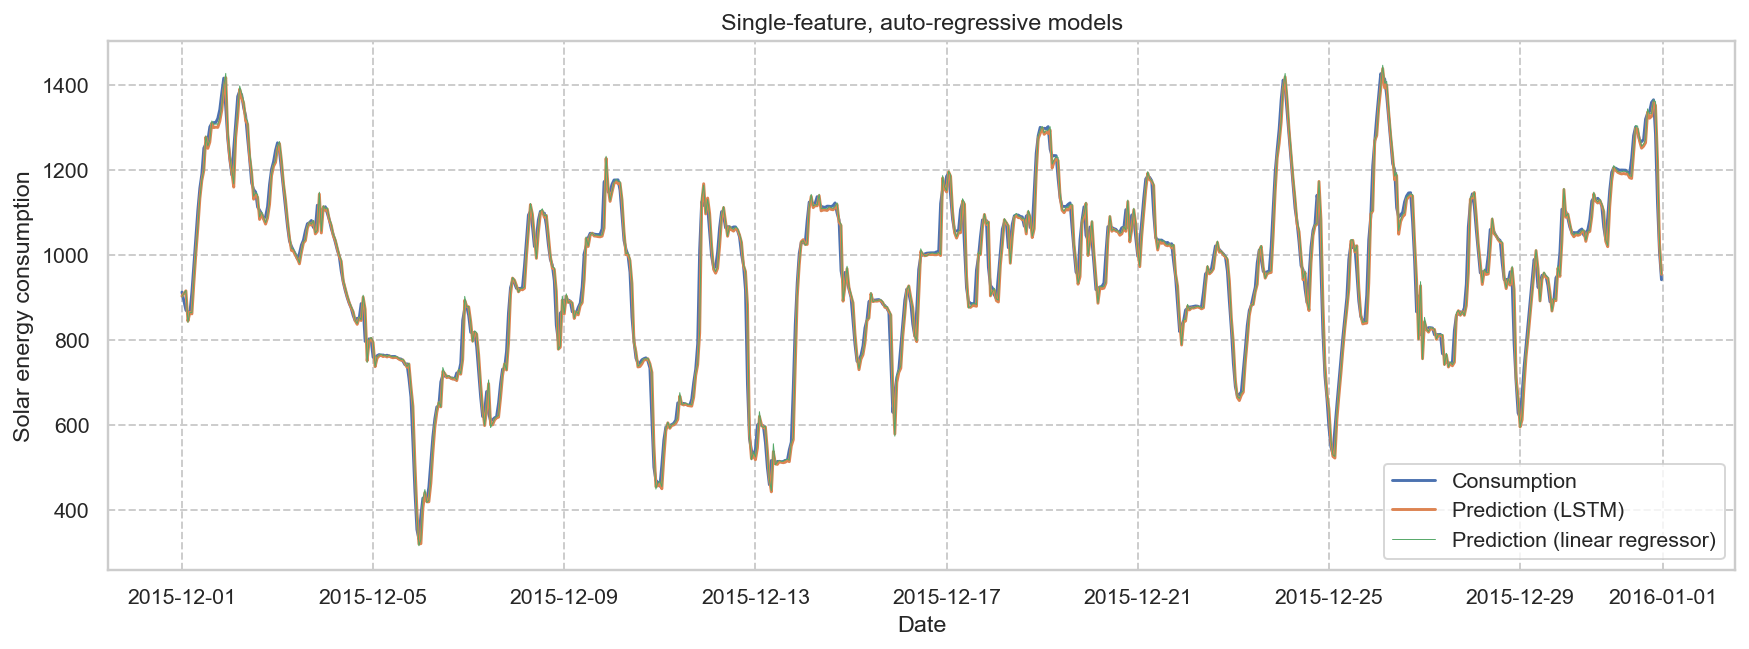

In [30]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_lstm_D, label='Prediction (LSTM)')
plt.plot(hours_df, y_pred_model_2, label='Prediction (linear regressor)', linewidth=0.5)
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.title('Single-feature, auto-regressive models')
plt.legend()
plt.savefig('roll_24_autoreg.png')
plt.show()

Next, we __repeat the experiment 10 times__ to obtain statistics of the metrics.

100%|██████████| 11/11 [07:17<00:00, 39.73s/it]


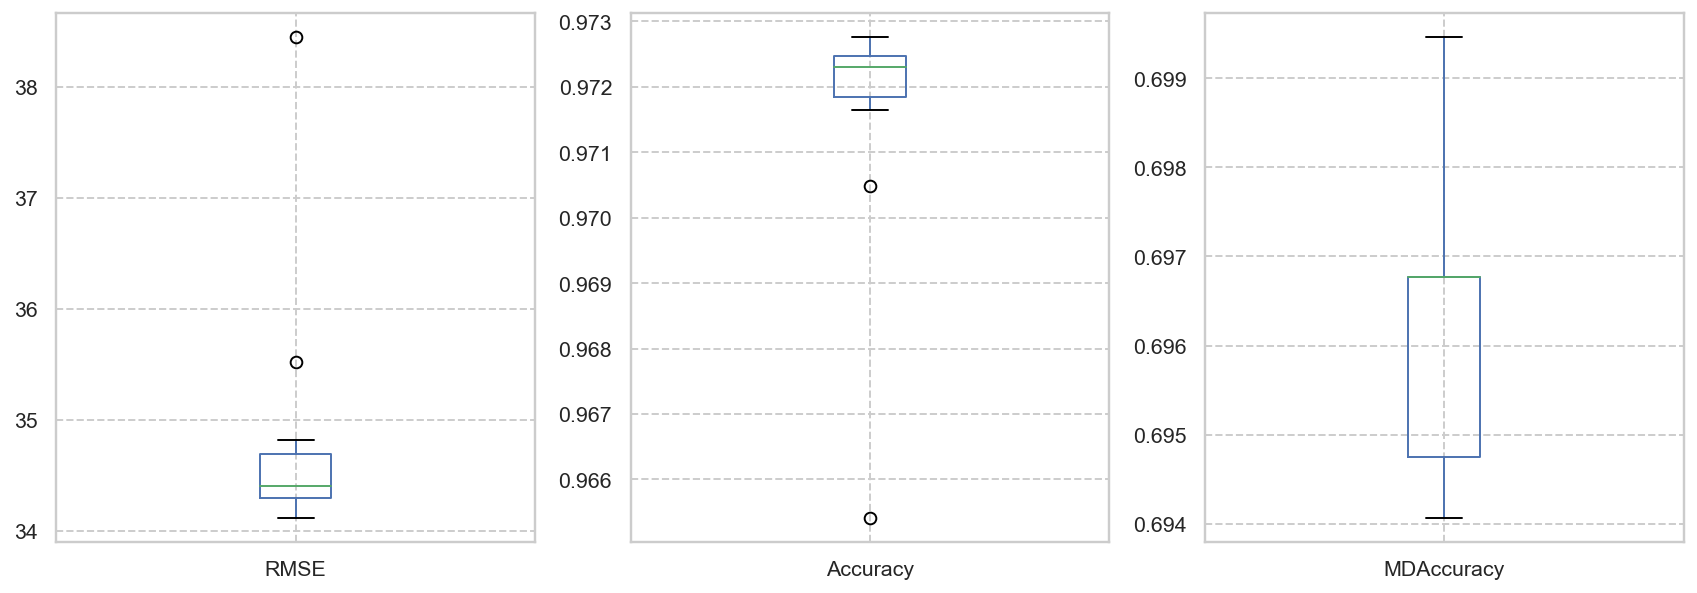

In [31]:
def lstm_net(X_train_in, y_train, X_test_in, y_test):
    
    model, history = fit_network(verbosity=0)
    y_pred_out = model.predict(X_test_in)

    # invert scaling for forecast and actual
    y_pred = inverting(y_pred_out)
    y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

    # metrics
    rmse = sqrt(MSE(y_inv, y_pred))
    LSTM_accuracy = r2_score(y_inv, y_pred)
    mean_da = mda(y_inv, y_pred)
    
    return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

import time
from tqdm import tqdm
    
rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
for i in tqdm(range(11)):  #31
    tqdm._instances.clear()
    
    rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test)
    
    rmse_l.append(rmse)
    y_inv_l.append(y_inv)
    y_pred_l.append(y_pred)
    acc_l.append(acc)
    mda_l.append(mdacc)
    
# getting the index of the median rmse value and extract the predictions of this value
rsme_df = pd.DataFrame(rmse_l)
rsme_med = pd.DataFrame(rmse_l).median().values[0]
ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
y_pred_lstm = y_pred_l[ind_med]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(rmse_l, columns=['RMSE']).boxplot(figsize=(7,6), ax=ax[0])
pd.DataFrame(acc_l, columns=['Accuracy']).boxplot(figsize=(7,6), ax=ax[1])
pd.DataFrame(mda_l, columns=['MDAccuracy']).boxplot(figsize=(7,6), ax=ax[2])
# plt.savefig('RMSE.pdf')
plt.show()

### E. Multi-feature, auto-regressive LSTM RNN.
---

We again select the train/validation/test sets in the same manner as before. However we now consider the full set of 12 features.

In [32]:
X_train, y_train = reframed_train.copy().iloc[:,:-12], reframed_train.copy().iloc[:,-1]
#
X_train_lstm, y_train_lstm = X_train[:'2015-10'], y_train[:'2015-10']
X_val, y_val = X_train['2015-11':], y_train['2015-11':]
X_test, y_test = reframed_test.copy().iloc[:,:-12], reframed_test.copy().iloc[:,-1]

# For LSTM, the imput shape is in the form of (samples, timesteps, features)
X_train_shape = (X_train_lstm.shape[0], 10, 12)
X_val_shape = (X_val.shape[0], 10, 12)
X_test_shape = (X_test.shape[0], 10, 12)

# reshape input to be 3D [samples, timesteps, features]
X_train_in = X_train_lstm.values.reshape(X_train_shape)
X_val_in = X_val.values.reshape(X_val_shape)
X_test_in = X_test.values.reshape(X_test_shape)
print('X_train_lstm:', X_train_lstm.shape, 'y_train_lstm:', y_train_lstm.shape, 
      '\nX_train_in:', X_train_in.shape, 
      '\nX_val_in:', X_val_in.shape, 'y_val:', y_val.shape,
      '\nX_test_in:', X_test_in.shape, 'X_test:', y_test.shape)

X_train_lstm: (7032, 120) y_train_lstm: (7032,) 
X_train_in: (7032, 10, 12) 
X_val_in: (715, 10, 12) y_val: (715,) 
X_test_in: (743, 10, 12) X_test: (743,)


#### 1. Fit

In [33]:
def fit_network(n_neurons=50, batch_size=72, epochs=100, optimizer='adam', verbosity=2):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train_in.shape[1], X_train_in.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    # Run network
    history = model.fit(X_train_in, y_train_lstm, epochs=epochs, batch_size=batch_size, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                        validation_data=(X_val_in, y_val), shuffle=False,
                        verbose=verbosity)
    
    return (model, history)

model_lstm, history = fit_network(verbosity=2)

Train on 7032 samples, validate on 715 samples
Epoch 1/100
 - 1s - loss: 0.1377 - mse: 0.0384 - val_loss: 0.1803 - val_mse: 0.0394
Epoch 2/100
 - 1s - loss: 0.1134 - mse: 0.0216 - val_loss: 0.1650 - val_mse: 0.0323
Epoch 3/100
 - 1s - loss: 0.0880 - mse: 0.0146 - val_loss: 0.0904 - val_mse: 0.0110
Epoch 4/100
 - 1s - loss: 0.0585 - mse: 0.0059 - val_loss: 0.0438 - val_mse: 0.0034
Epoch 5/100
 - 1s - loss: 0.0409 - mse: 0.0029 - val_loss: 0.0335 - val_mse: 0.0022
Epoch 6/100
 - 1s - loss: 0.0345 - mse: 0.0022 - val_loss: 0.0306 - val_mse: 0.0019
Epoch 7/100
 - 1s - loss: 0.0322 - mse: 0.0019 - val_loss: 0.0327 - val_mse: 0.0020
Epoch 8/100
 - 1s - loss: 0.0340 - mse: 0.0020 - val_loss: 0.0288 - val_mse: 0.0016
Epoch 9/100
 - 1s - loss: 0.0310 - mse: 0.0017 - val_loss: 0.0425 - val_mse: 0.0027
Epoch 10/100
 - 1s - loss: 0.0312 - mse: 0.0017 - val_loss: 0.0286 - val_mse: 0.0015
Epoch 11/100
 - 1s - loss: 0.0279 - mse: 0.0013 - val_loss: 0.0306 - val_mse: 0.0016
Epoch 12/100
 - 1s - loss: 

Test loss: 0.01691914013114383
Test mean squared error: 0.0004931483999826014


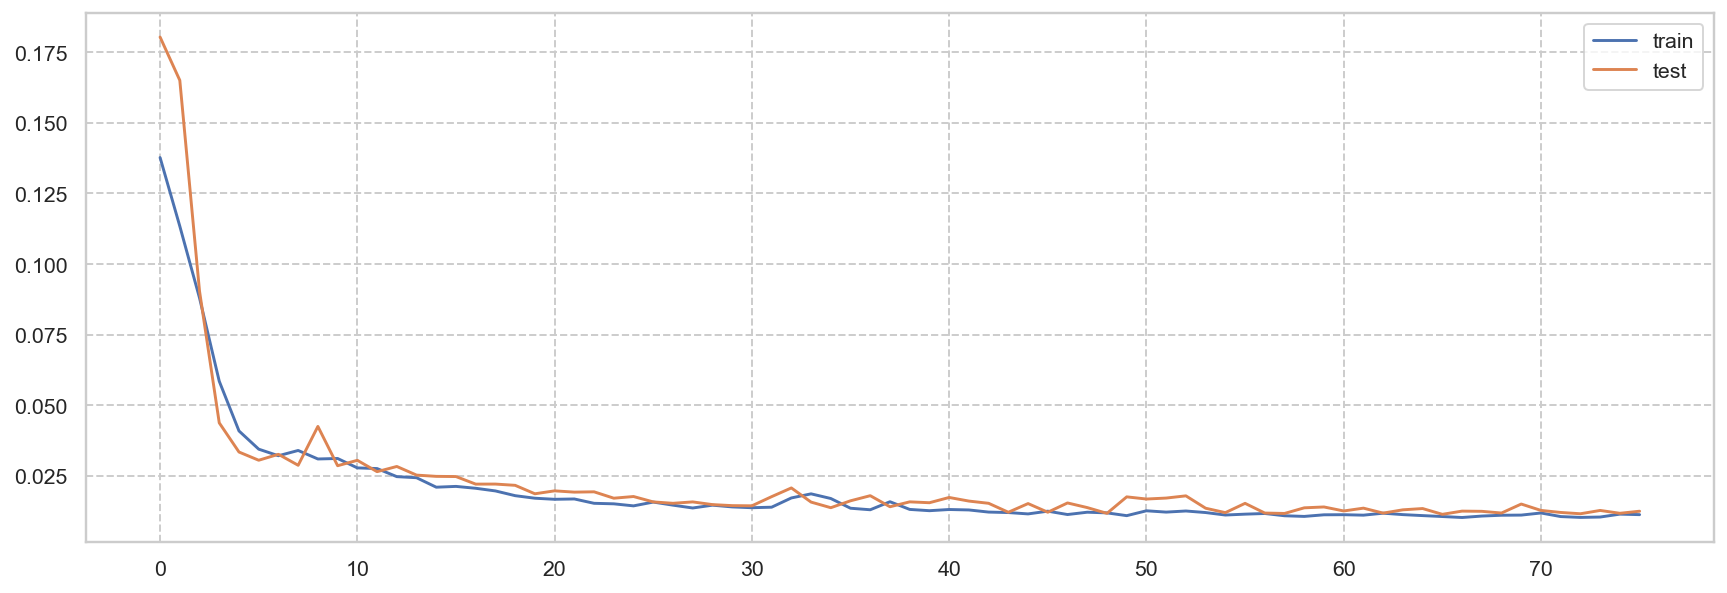

In [34]:
loss, mse = model_lstm.evaluate(X_test_in, y_test, verbose=0)
print('Test loss:', loss)
print('Test mean squared error:', mse)

# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 2. Performance

In [35]:
y_pred_out = model_lstm.predict(X_test_in)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]

y_pred_lstm_E = inverting(y_pred_out)
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#======================================================= metrics
# calculate RMSE
rmse_lstm = sqrt(MSE(y_inv, y_pred_lstm_E))
print('Test RMSE: %.3f' % rmse_lstm)

# calculate model accuracy
accuracy_lstm = r2_score(y_inv, y_pred_lstm_E)
print('Model accuracy: {:.3f}'.format(accuracy_lstm))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) 
                    == np.sign(predicted[1:] - predicted[:-1])).astype(int))
mda_lstm = mda(y_inv, y_pred_lstm_E)

print('Model Mean Directional accuracy: {:.3f}'.format(mda_lstm))

Test RMSE: 39.480
Model accuracy: 0.964
Model Mean Directional accuracy: 0.705


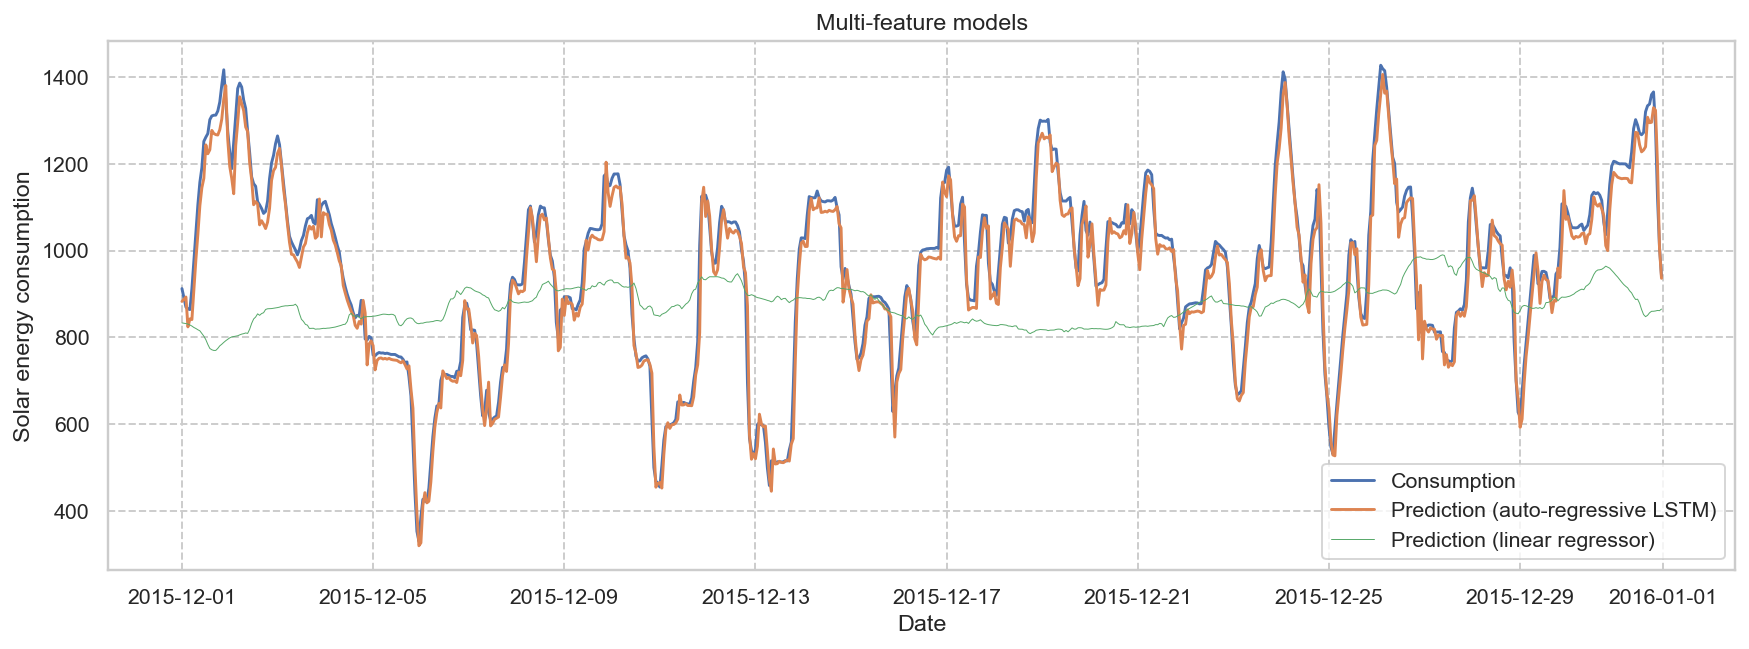

In [36]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_lstm_E, label='Prediction (auto-regressive LSTM)')
plt.plot(hours_df, y_pred_model_1, label='Prediction (linear regressor)', linewidth=0.5)
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.title('Multi-feature models')
plt.savefig('roll_24_multi.png')
plt.legend()
plt.show()

Next, we __repeat the experiment 30 times__ to obtain statistics of the metrics.

100%|██████████| 11/11 [07:13<00:00, 39.44s/it]


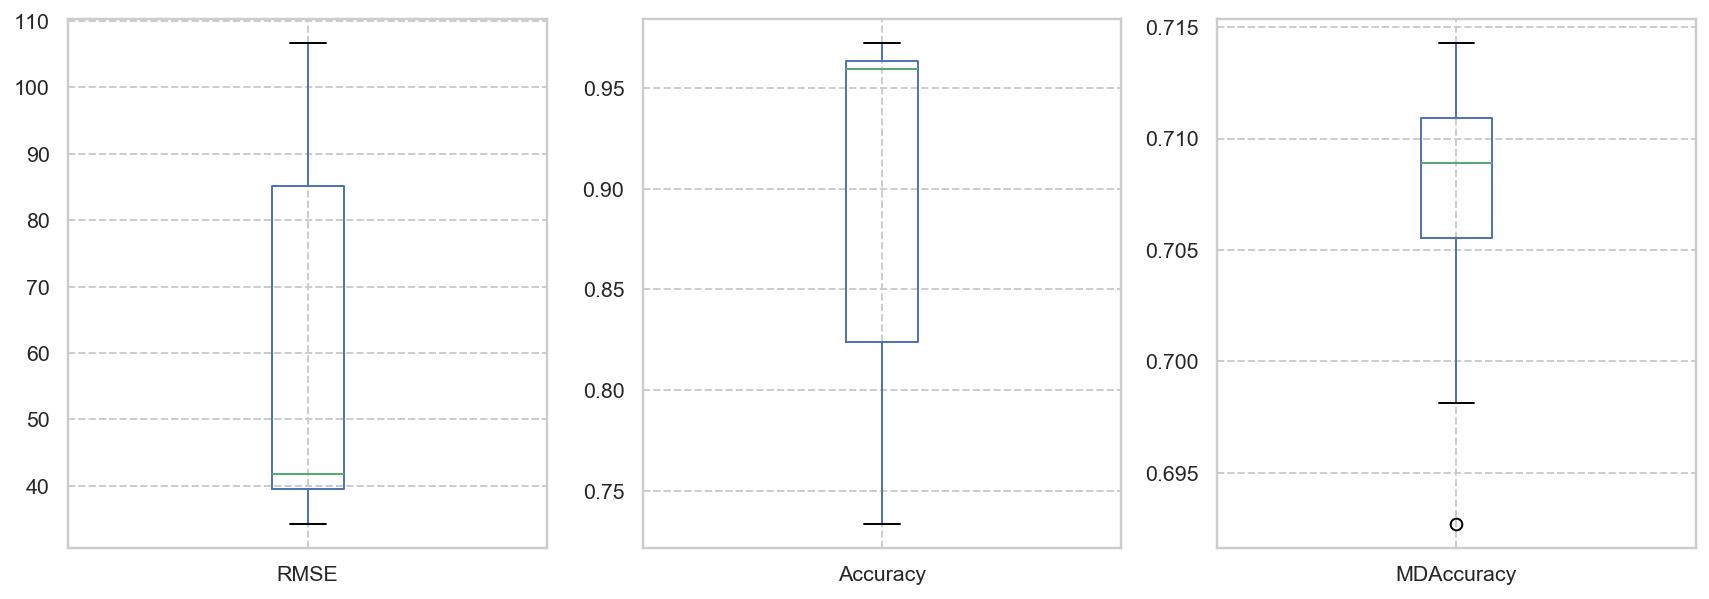

In [37]:
def lstm_net(X_train_in, y_train, X_test_in, y_test):
    
    model, history = fit_network(verbosity=0)
    y_pred_out = model.predict(X_test_in)

    # invert scaling for forecast and actual
    y_pred = inverting(y_pred_out)
    y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

    # metrics
    rmse = sqrt(MSE(y_inv, y_pred))
    LSTM_accuracy = r2_score(y_inv, y_pred)
    mean_da = mda(y_inv, y_pred)
    
    return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

import time
from tqdm import tqdm
    
rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
for i in tqdm(range(11)):  #31
    tqdm._instances.clear()
    
    rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test)
    
    rmse_l.append(rmse)
    y_inv_l.append(y_inv)
    y_pred_l.append(y_pred)
    acc_l.append(acc)
    mda_l.append(mdacc)
    
# getting the index of the median rmse value and extract the predictions of this value
rsme_df = pd.DataFrame(rmse_l)
rsme_med = pd.DataFrame(rmse_l).median().values[0]
ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
y_pred_lstm = y_pred_l[ind_med]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(rmse_l, columns=['RMSE']).boxplot(figsize=(7,6), ax=ax[0])
pd.DataFrame(acc_l, columns=['Accuracy']).boxplot(figsize=(7,6), ax=ax[1])
pd.DataFrame(mda_l, columns=['MDAccuracy']).boxplot(figsize=(7,6), ax=ax[2])
# plt.savefig('RMSE.pdf')
plt.show()

### F. Multi-feature LSTM RNN.
---

We again select the train/validation/test sets in the same manner as before. However we now consider the full set of 12 features.

In [38]:
X_train, y_train = reframed_train.copy().iloc[:,-12:-1], reframed_train.copy().iloc[:,-1]
#
X_train_lstm, y_train_lstm = X_train[:'2015-10'], y_train[:'2015-10']
X_val, y_val = X_train['2015-11':], y_train['2015-11':]
X_test, y_test = reframed_test.copy().iloc[:,-12:-1], reframed_test.copy().iloc[:,-1]

# For LSTM, the imput shape is in the form of (samples, timesteps, features)
X_train_shape = (X_train_lstm.shape[0], 1, 11)
X_val_shape = (X_val.shape[0], 1, 11)
X_test_shape = (X_test.shape[0], 1, 11)

# reshape input to be 3D [samples, timesteps, features]
X_train_in = X_train_lstm.values.reshape(X_train_shape)
X_val_in = X_val.values.reshape(X_val_shape)
X_test_in = X_test.values.reshape(X_test_shape)
print('X_train_lstm:', X_train_lstm.shape, 'y_train_lstm:', y_train_lstm.shape, 
      '\nX_train_in:', X_train_in.shape, 
      '\nX_val_in:', X_val_in.shape, 'y_val:', y_val.shape,
      '\nX_test_in:', X_test_in.shape, 'X_test:', y_test.shape)

X_train_lstm: (7032, 11) y_train_lstm: (7032,) 
X_train_in: (7032, 1, 11) 
X_val_in: (715, 1, 11) y_val: (715,) 
X_test_in: (743, 1, 11) X_test: (743,)


#### 1. Fit

In [39]:
def fit_network(n_neurons=50, batch_size=72, epochs=100, optimizer='adam', verbosity=2):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train_in.shape[1], X_train_in.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    # Run network
    history = model.fit(X_train_in, y_train_lstm, epochs=epochs, batch_size=batch_size, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                        validation_data=(X_val_in, y_val), shuffle=False,
                        verbose=verbosity)
    
    return (model, history)

model_lstm, history = fit_network(verbosity=2)

Train on 7032 samples, validate on 715 samples
Epoch 1/100
 - 1s - loss: 0.1943 - mse: 0.0691 - val_loss: 0.0921 - val_mse: 0.0138
Epoch 2/100
 - 0s - loss: 0.1531 - mse: 0.0389 - val_loss: 0.0908 - val_mse: 0.0136
Epoch 3/100
 - 0s - loss: 0.1508 - mse: 0.0378 - val_loss: 0.0901 - val_mse: 0.0135
Epoch 4/100
 - 0s - loss: 0.1485 - mse: 0.0368 - val_loss: 0.0882 - val_mse: 0.0132
Epoch 5/100
 - 0s - loss: 0.1463 - mse: 0.0358 - val_loss: 0.0879 - val_mse: 0.0131
Epoch 6/100
 - 0s - loss: 0.1450 - mse: 0.0352 - val_loss: 0.0871 - val_mse: 0.0130
Epoch 7/100
 - 0s - loss: 0.1439 - mse: 0.0347 - val_loss: 0.0860 - val_mse: 0.0126
Epoch 8/100
 - 0s - loss: 0.1427 - mse: 0.0341 - val_loss: 0.0849 - val_mse: 0.0123
Epoch 9/100
 - 0s - loss: 0.1413 - mse: 0.0334 - val_loss: 0.0841 - val_mse: 0.0119
Epoch 10/100
 - 0s - loss: 0.1396 - mse: 0.0327 - val_loss: 0.0839 - val_mse: 0.0118
Epoch 11/100
 - 0s - loss: 0.1386 - mse: 0.0322 - val_loss: 0.0840 - val_mse: 0.0116
Epoch 12/100
 - 0s - loss: 

Test loss: 0.1097016414755286
Test mean squared error: 0.017658187076449394


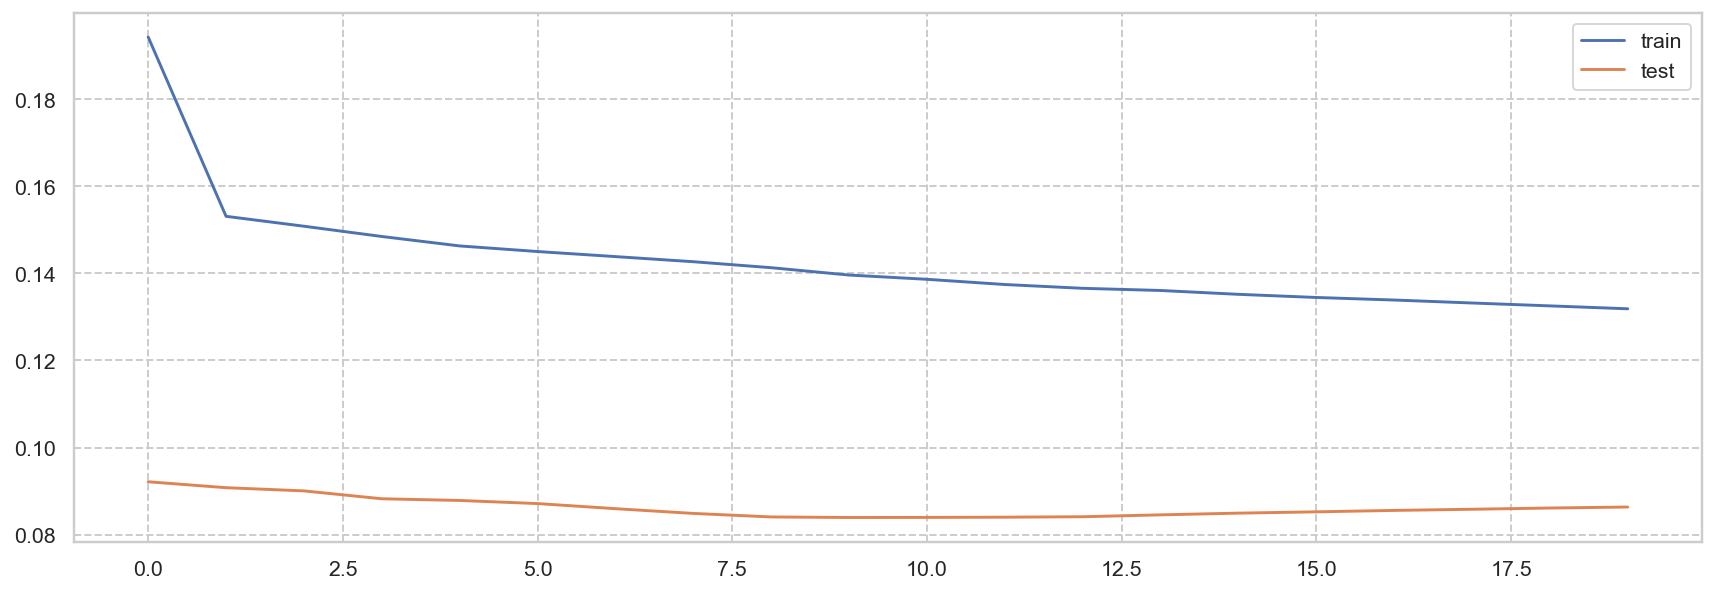

In [40]:
loss, mse = model_lstm.evaluate(X_test_in, y_test, verbose=0)
print('Test loss:', loss)
print('Test mean squared error:', mse)

# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 2. Performance

In [41]:
y_pred_out = model_lstm.predict(X_test_in)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]

y_pred_lstm_F = inverting(y_pred_out)
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#======================================================= metrics
# calculate RMSE
rmse_lstm = sqrt(MSE(y_inv, y_pred_lstm_F))
print('Test RMSE: %.3f' % rmse_lstm)

# calculate model accuracy
accuracy_lstm = r2_score(y_inv, y_pred_lstm_F)
print('Model accuracy: {:.3f}'.format(accuracy_lstm))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) 
                    == np.sign(predicted[1:] - predicted[:-1])).astype(int))
mda_lstm = mda(y_inv, y_pred_lstm_F)

print('Model Mean Directional accuracy: {:.3f}'.format(mda_lstm))

Test RMSE: 236.246
Model accuracy: -0.306
Model Mean Directional accuracy: 0.536


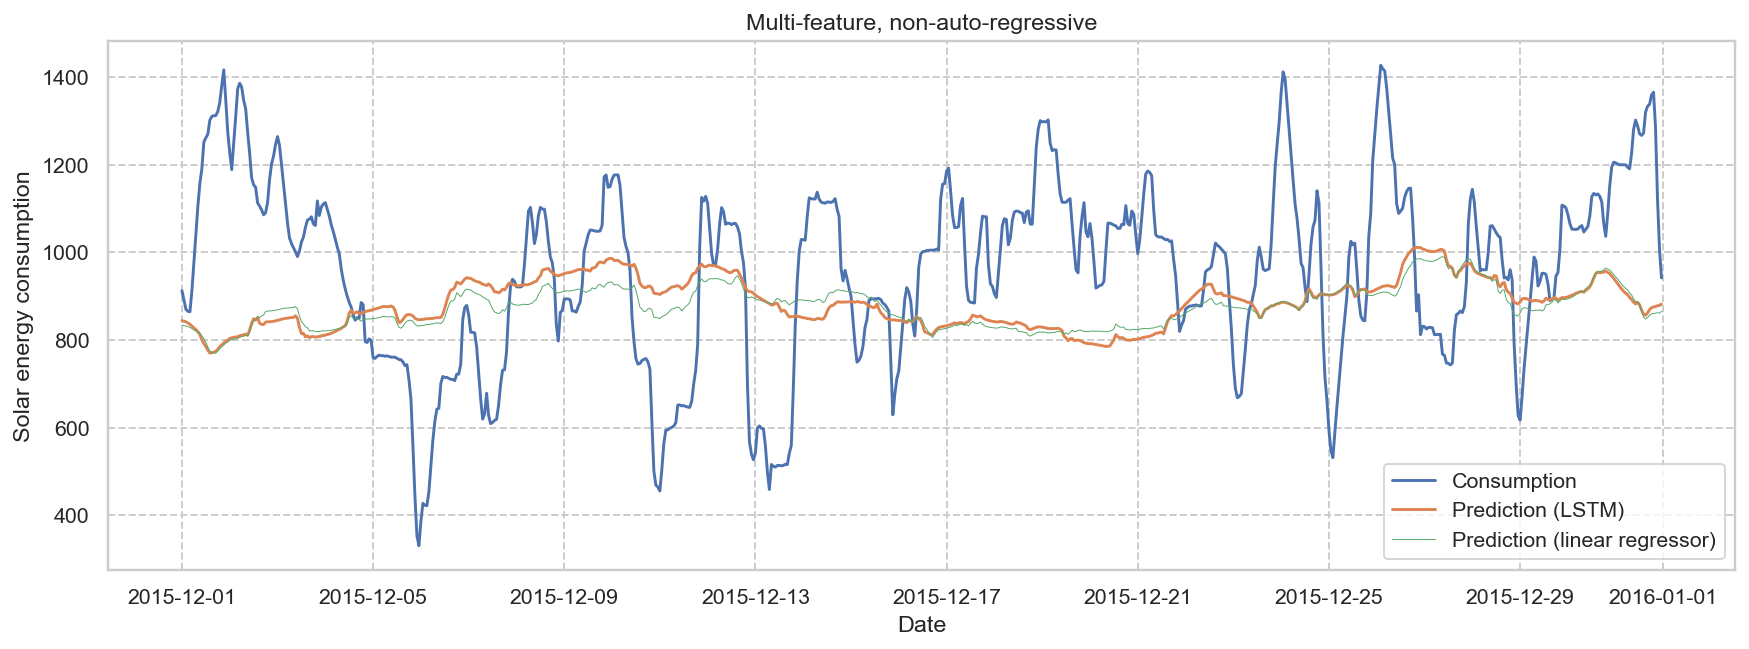

In [42]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_lstm_F, label='Prediction (LSTM)')
plt.plot(hours_df, y_pred_model_1, label='Prediction (linear regressor)', linewidth=0.5)
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.title('Multi-feature, non-auto-regressive')
plt.legend()
plt.show()

## 3. Summary

## 4. References
---

1. [On the Suitability of Long Short-Term Memory Networks for Time Series Forecasting](https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/)

2. [How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

3. [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

4. [Get the Most out of LSTMs on Your Sequence Prediction Problem](https://machinelearningmastery.com/get-the-most-out-of-lstms/)

5. [Multi-step Time Series Forecasting with Long Short-Term Memory Networks in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)

6. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### Notes

A first draft covering some parts of the data preparation and a few other blocks of code were provided by the HackDay organizers, however the completition of this project was carried out individually by the author.